<img src='https://img.rasset.ie/00087d62-800.jpg' width='60%' align='center'>

---
<h1 align='center'>Fannie Mae Mortgage Default Analysis</h1>
<h2 align='center'>Predictive Modelling with Machine Learning</h2>
<h3 align='center'>By Jeffery Chu Yun Qiang</h3>

---

# Improvements

Based on file 'Fannie Mae Mortgage Default Prediction Project (Pandas) - V2.7 (Fully Working Original).ipynb'.

1. Binning of all variables
3. Put the list in this for loop outside as a variable as this is hard to read
    for x in [column for column in perf_df.columns if column not in ['rep_year','rep_quarter','rep_period','id',
                                                                 'curr_act_upb','curr_int_rate','loan_age',
                                                                 'remaining_months_legal','adjusted_months_legal',
                                                                 'all_diff_in_months','curr_ltv_diff_perc']]:
4. for dummies, make everything ready till before train/test split, then dummy the whole dataframe. Won't have to dummy each variable separately. The function will leave numeric fields and only convert string columns.
5. Combine all results into one chart

# End - Improvements

---
The mortgage market in the USA is a \\$10 trillion industry and its performance has a significant bearing on the US economy. The housing market crash of 2008 depressed the US economical engine such that it led to a worldwide downturn in economic activity. Fannie Mae and its brother entity Freddie Mac suffered large losses and required government bailout to survive the crash, to the tune of around \\$200 billion. Some of the reasons cited include low interest rates/easy credit, poor regulation and toxic mortgages.

It is thus interesting to explore and analyse the Fannie Mae mortgage dataset that has been made available by Fannie Mae. The dataset is part of a drive by the US government to encourage greater transparency in credit performance evaluation and is available from [Fannie Mae's website](https://loanperformancedata.fanniemae.com/lppub/index.html). It is large (around 170 GB for the full set) and contains acquisition and monthly performance data on loans that originated from the year 2000 to 2017. 

We will use the 2007 Q4 data set to develop default prediction models using various machine learning algorithms. Being a machine learning project, we need to be methodical and go through the following major steps to properly develop a successful model:

### Structure of Project
1. Definition of target labels
2. Data exploration
3. Feature pre-processing and selection
4. Development and training of predictive models
5. Evaluation of models and metrics comparisons
6. Iterate and improve as necessary

### Definition of Default
We will structure this as a binary classification problem and define a mortgage to have defaulted if payment has been missed for 90 days or more. This is based on the [BASEL II definition of loan default](https://www.federalreserve.gov/boarddocs/press/bcreg/2004/20040626/attachment.pdf). Mortgages that fit this criteria will be labelled with '1' while loans that have not defaulted will be labelled with '0'.

### Dataset Tables
The mortgage dataset consists of 2 main tables:
1. Acquisition
2. Performance

In [1]:
# Import all needed modules

import numpy as np
import pandas as pd
import re
import math
import itertools
import missingno as msno
import seaborn as sns
from plotnine import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pylab import rc, rcParams
%matplotlib inline

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import xgboost as xgb

# SMOTE
from collections import Counter
from imblearn.over_sampling import SMOTE

# Set Pandas view options as needed
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

<h1 align='center'>Data Exploration</h1>

We will start with data exploration of each table to check the completeness of information. Fields that have too much missing data will need to be discarded.  


### Exploration - Acquisition Data

The data columns are mapped according to the file format published on Fannie Mae's [dataset FAQs](https://loanperformancedata.fanniemae.com/lppub-docs/FNMA_SF_Loan_Performance_File_layout.pdf). 

In [2]:
# Acquisition File Column and Data Type Definition

acq_cols = ['id_A',
            'orig_channel_A',
            'seller_name_A',
            'orig_int_rate_A',
            'orig_upb_A',
            'orig_loan_term_A',
            'orig_date_A',
            'first_pay_date_A',
            'orig_ltv_A',
            'orig_cltv_A',
            'borrowers_A',
            'orig_dtir_A',
            'borrower_credit_score_A',
            'first_time_buyer_A',
            'purpose_A',
            'property_type_A',
            'num_of_units_A',
            'occupancy_type_A',
            'state_A',
            'zip_A',
            'insurance_perc_A',
            'product_type_A',
            'co_borrower_credit_score_A',
            'insurance_type_A',
            'relocation_A']

acq_dtypes = {'id_A':'int64',
              'orig_channel_A':'object',
              'seller_name_A':'object',
              'orig_int_rate_A':'float64',
              'orig_upb_A':'float64',
              'orig_loan_term_A':'int64',
              'orig_date_A':'object',
              'first_pay_date_A':'object',
              'orig_ltv_A':'float64',
              'orig_cltv_A':'float64',
              'borrowers_A':'float64',
              'orig_dtir_A':'float64',
              'borrower_credit_score_A':'float64',
              'first_time_buyer_A':'object',
              'purpose_A':'object',
              'property_type_A':'object',
              'num_of_units_A':'object',
              'occupancy_type_A':'object',
              'state_A':'object',
              'zip_A':'object',
              'insurance_perc_A':'float64',
              'product_type_A':'object',
              'co_borrower_credit_score_A':'float64',
              'insurance_type_A':'float64',
              'relocation_A':'object'}

# Load Acquisition File (update to your own file path)
acq_df = pd.read_csv('/mnt/d/Users/machine_learning_projects/Fannie Mae/2007Q4/Acquisition_2007Q4.txt', 
                     sep='|', names=acq_cols, dtype=acq_dtypes)
acq_exp_df = acq_df.copy()

print('Dimensions:{}'.format(acq_exp_df.shape))
display(acq_exp_df.head(10))

Dimensions:(391209, 25)


,id_A,orig_channel_A,seller_name_A,orig_int_rate_A,orig_upb_A,orig_loan_term_A,orig_date_A,first_pay_date_A,orig_ltv_A,orig_cltv_A,borrowers_A,orig_dtir_A,borrower_credit_score_A,first_time_buyer_A,purpose_A,property_type_A,num_of_units_A,occupancy_type_A,state_A,zip_A,insurance_perc_A,product_type_A,co_borrower_credit_score_A,insurance_type_A,relocation_A
0,100002296854,C,"BANK OF AMERICA, N.A.",6.625,343000.0,360,10/2007,12/2007,86.0,86.0,2.0,27.0,751.0,N,C,PU,1,P,CO,809,25.0,FRM,756.0,2.0,N
1,100006876815,C,"BANK OF AMERICA, N.A.",6.250,400000.0,360,10/2007,12/2007,62.0,62.0,2.0,35.0,804.0,N,P,SF,1,P,CA,920,NaN,FRM,790.0,NaN,N
2,100008184591,B,OTHER,6.625,81000.0,360,11/2007,01/2008,64.0,82.0,1.0,53.0,585.0,N,R,SF,1,P,LA,708,NaN,FRM,NaN,NaN,N
3,100008870761,B,AMTRUST BANK,6.500,119000.0,360,11/2007,01/2008,71.0,71.0,1.0,35.0,646.0,N,R,CO,1,P,IL,600,NaN,FRM,NaN,NaN,N
4,100013284158,B,"BANK OF AMERICA, N.A.",6.625,205000.0,360,10/2007,12/2007,27.0,27.0,1.0,54.0,591.0,N,C,SF,1,P,CA,907,NaN,FRM,NaN,NaN,N
5,100016840211,R,"PNC BANK, N.A.",6.375,210000.0,360,08/2007,10/2007,80.0,93.0,1.0,42.0,787.0,N,P,SF,1,P,PA,160,NaN,FRM,NaN,NaN,N
6,100023772994,R,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",6.750,172000.0,360,09/2007,11/2007,95.0,95.0,1.0,42.0,698.0,N,P,CO,1,P,IL,605,30.0,FRM,NaN,1.0,N
7,100026162343,B,"BANK OF AMERICA, N.A.",6.875,108000.0,360,11/2007,01/2008,90.0,90.0,2.0,51.0,647.0,N,P,SF,2,I,MO,631,25.0,FRM,668.0,1.0,N
8,100030319603,C,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",6.250,175000.0,180,10/2007,12/2007,70.0,70.0,1.0,53.0,662.0,N,C,SF,1,P,IL,601,NaN,FRM,NaN,NaN,N
9,100031046995,C,"BANK OF AMERICA, N.A.",6.500,224000.0,360,10/2007,12/2007,62.0,62.0,1.0,50.0,744.0,N,R,PU,1,P,AZ,850,NaN,FRM,NaN,NaN,N


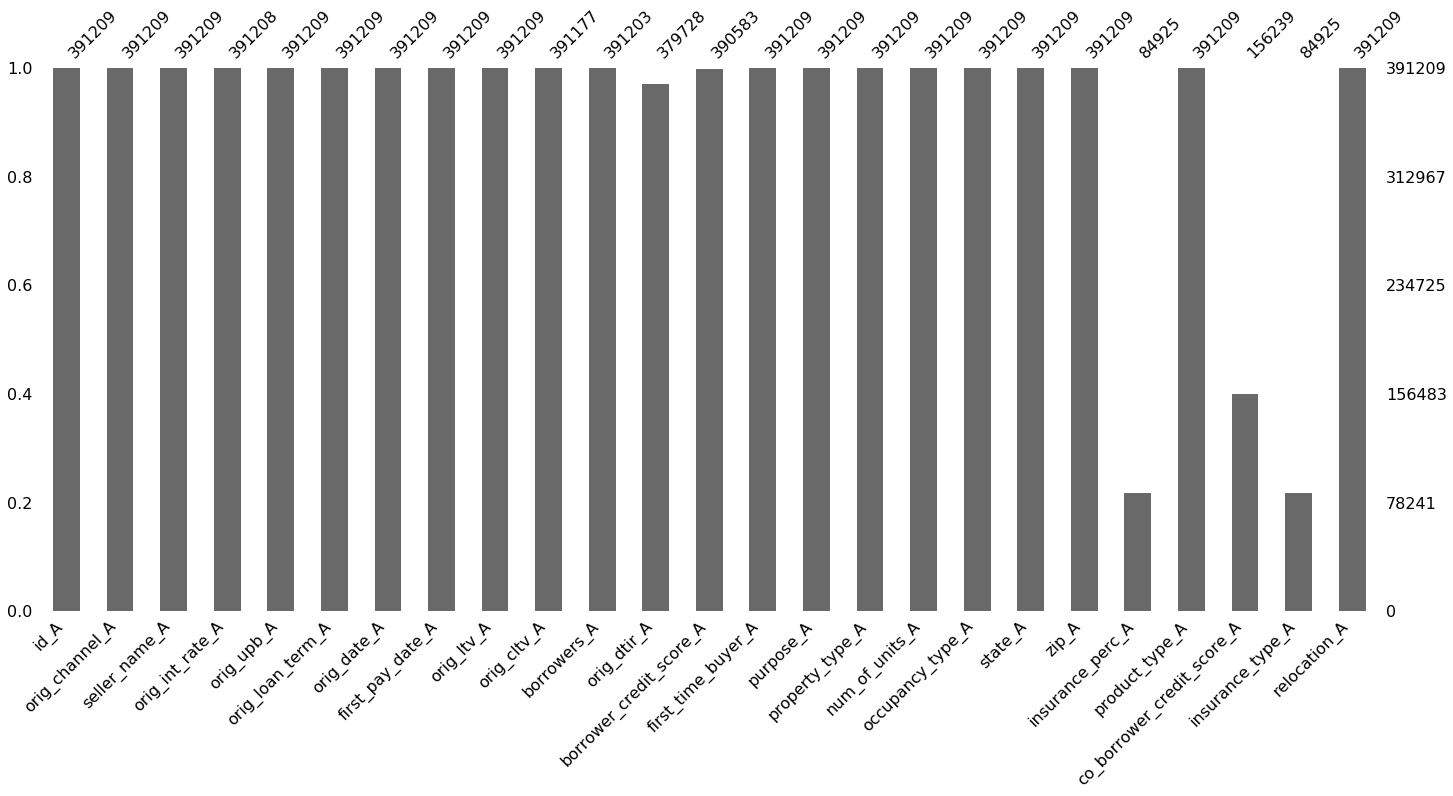

In [3]:
# Plot bar chart of missing data
msno.bar(acq_exp_df)

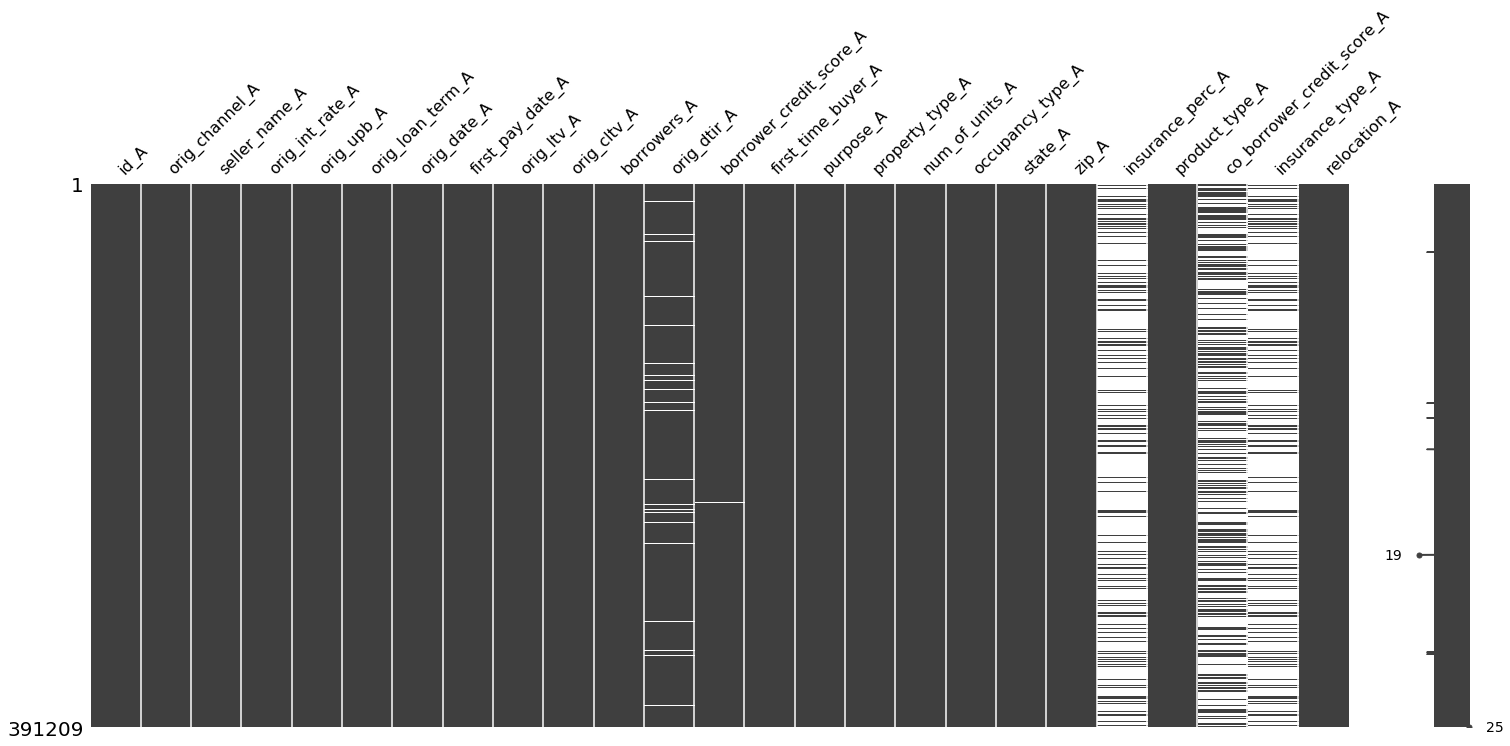

In [4]:
# Visulize missing data in acquisition table
msno.matrix(acq_exp_df)

<br>
Most of the fields are fully filled. Some fields like 'insurance_perc_A' and 'co_borrower_credit_score_A' are sparse and will need to be removed during data-preprocessing. 

Next, we will create some kernel density plots to get a better sense of the distribution of data fields.

### Kernel Density plot of Debt-to-Income Ratio

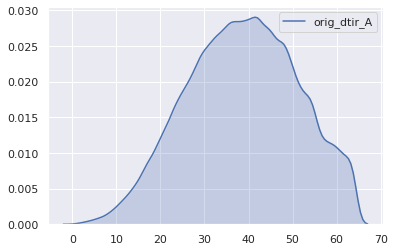

In [5]:
sns.set(style='darkgrid')
trace = acq_exp_df['orig_dtir_A'][~acq_exp_df['orig_dtir_A'].isnull()]
ax = sns.kdeplot(trace, shade=True)

We see that most of the loans are centered around a debt-to-income-ratio of 40.

### Kernel Density plot of Original Loan-to-Value Ratio

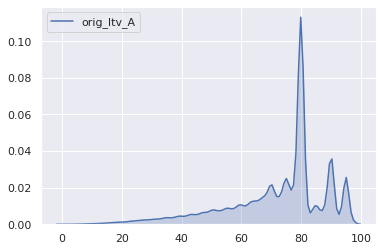

In [6]:
sns.set(style='darkgrid')
trace = acq_exp_df['orig_ltv_A'][~acq_exp_df['orig_ltv_A'].isnull()]
ax = sns.kdeplot(trace, shade=True)

There is a large concentration of mortgages with a loan-to-value ratio of about 80. 

### Kernel Density plot of Credit Scores

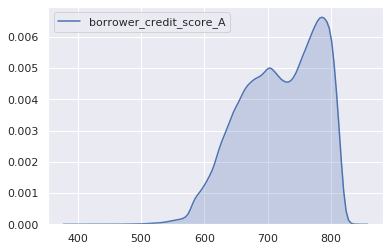

In [7]:
sns.set(style='darkgrid')
trace = acq_exp_df['borrower_credit_score_A'][~acq_exp_df['borrower_credit_score_A'].isnull()]
ax = sns.kdeplot(trace, shade=True)

The vast majority of loans are between credit scores of 600 to 800. 

### Pair plot of 'Original Loan Term', 'Original Loan Amount' and '1st Time Buyer Indicator'

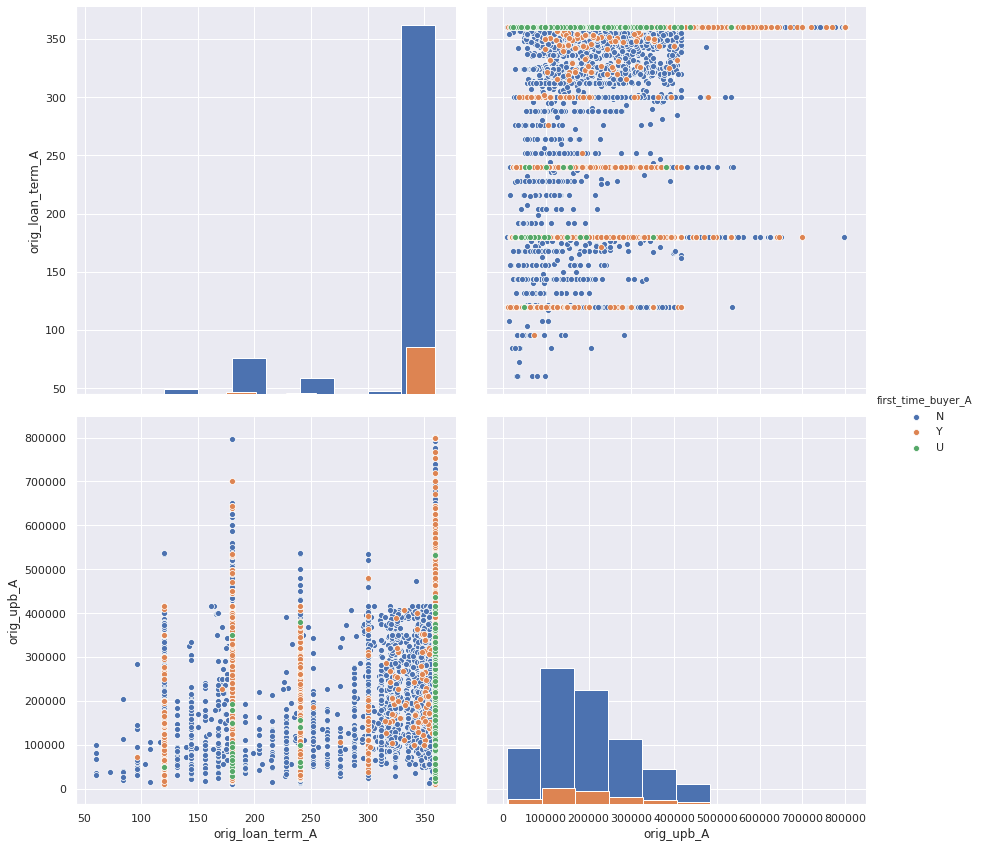

In [8]:
# For palette=sns.cubehelix_palette(n_colors=3, start=200, rot=4, light=0.5, dark=0.5)
# palette=sns.color_palette('GnBu_r', desat=1, n_colors=10)

sns.pairplot(acq_exp_df[['orig_loan_term_A','orig_upb_A','first_time_buyer_A']], height=6, 
             hue='first_time_buyer_A', diag_kind='hist')

<br>
Based on the above graph, we can see that most of the loans that originated in 2007 Q4 were not from first-time home buyers and instead from people who have already bought one or more property assets. 

## Exploration - Performance Data
Examining the file layout, we will join the performance table to the acquisition table so that we can compare the default rates to the potential features on the acquisition table.

The data columns are mapped according to the file format published on Fannie Mae's [dataset FAQs](https://loanperformancedata.fanniemae.com/lppub-docs/FNMA_SF_Loan_Performance_File_layout.pdf). 

In [9]:
# Performance File Column and Data Type Definition

perf_cols = ['id',
             'rep_period',
             'servicer',
             'curr_int_rate',
             'curr_act_upb',
             'loan_age',
             'remaining_months_legal',
             'adjusted_months_legal',
             'maturity_date',
             'MSA',
             'current_loan_stat',
             'mod_flag',
             'zero_bal_code',
             'zero_bal_date',
             'last_paid_date',
             'foreclosure_date',
             'disposition_date',
             'foreclosure_cost',
             'preservation_costs',
             'recovery_costs',
             'holding_expenses_and_credits',
             'holding_tax',
             'net_sale_proceeds',
             'credit_enhance_proceeds',
             'make_whole_proceeds',
             'other_proceeds',
             'non_int_bearing_upd',
             'principal_forgiveness_amount',
             'make_whole_proceeds_flag',
             'foreclosure_principal_write_off',
             'servicing_activity_indicator']

perf_dtypes = {'id':'int64',
               'rep_period':'object',
               'servicer':'object',
               'curr_int_rate':'float64',
               'curr_act_upb':'float64',
               'loan_age':'int64',
               'remaining_months_legal':'float64',
               'adjusted_months_legal':'float64',
               'maturity_date':'object',
               'MSA':'object',
               'current_loan_stat':'object',
               'mod_flag':'object',
               'zero_bal_code':'object',
               'zero_bal_date':'object',
               'last_paid_date':'object',
               'foreclosure_date':'object',
               'disposition_date':'object',
               'foreclosure_cost':'float64',
               'preservation_costs':'float64',
               'recovery_costs':'float64',
               'holding_expenses_and_credits':'float64',
               'holding_tax':'float64',
               'net_sale_proceeds':'float64',
               'credit_enhance_proceeds':'float64',
               'make_whole_proceeds':'float64',
               'other_proceeds':'float64',
               'non_int_bearing_upd':'float64',
               'principal_forgiveness_amount':'float64',
               'make_whole_proceeds_flag':'object',
               'foreclosure_principal_write_off':'float64',
               'servicing_activity_indicator':'object'}

# Load Performance File
perf_df = pd.read_csv('/mnt/d/Users/machine_learning_projects/Fannie Mae/2007Q4/Performance_2007Q4.txt', sep='|',
                      names=perf_cols, dtype=perf_dtypes)
perf_exp_df = perf_df.copy()
print('Dimensions:{}'.format(perf_exp_df.shape))

Dimensions:(20618621, 31)


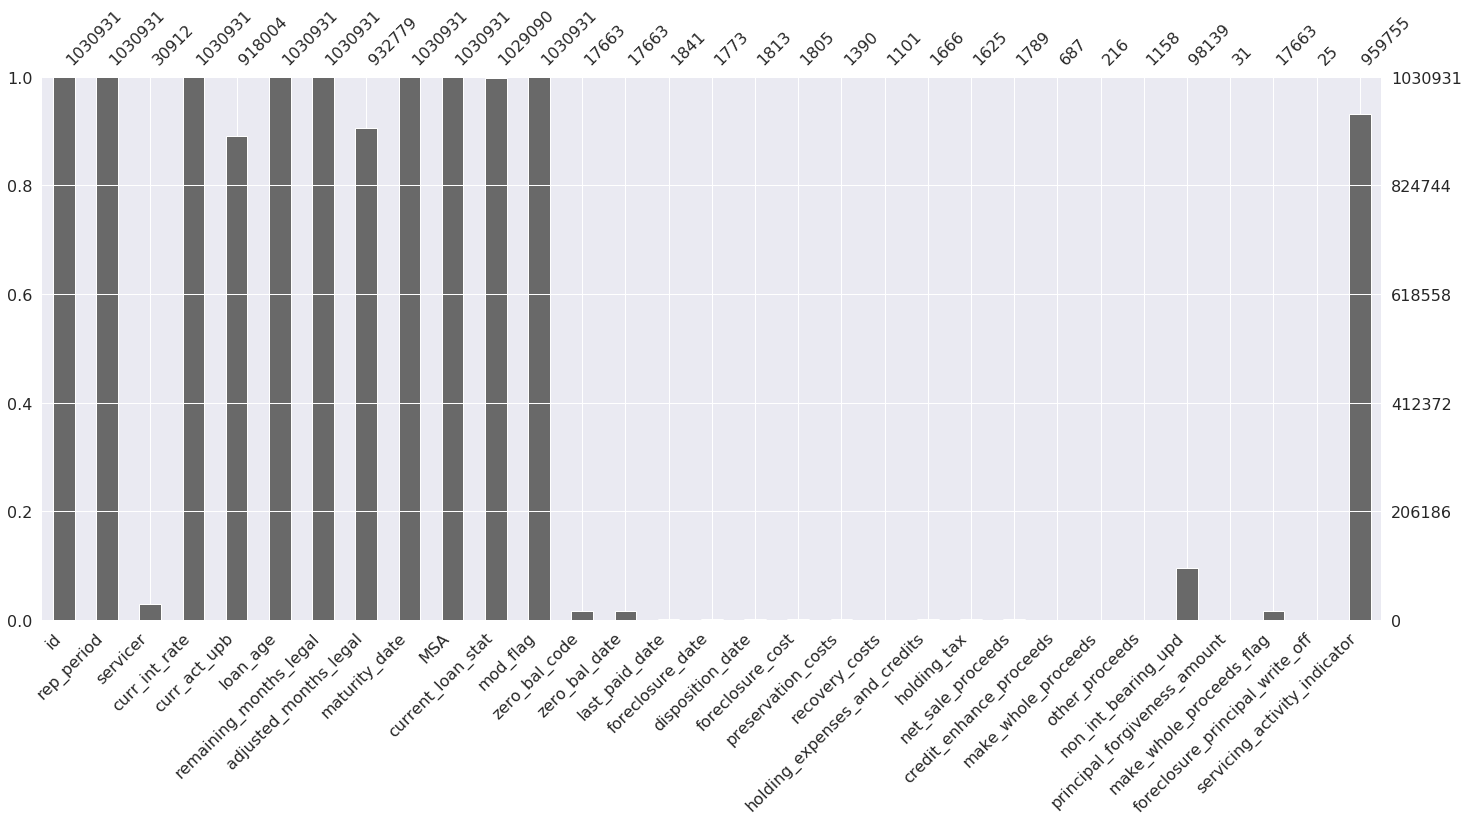

In [10]:
# Plot bar chart of missing data in performance table
msno.bar(perf_exp_df.sample(int(len(perf_df)*0.05)))

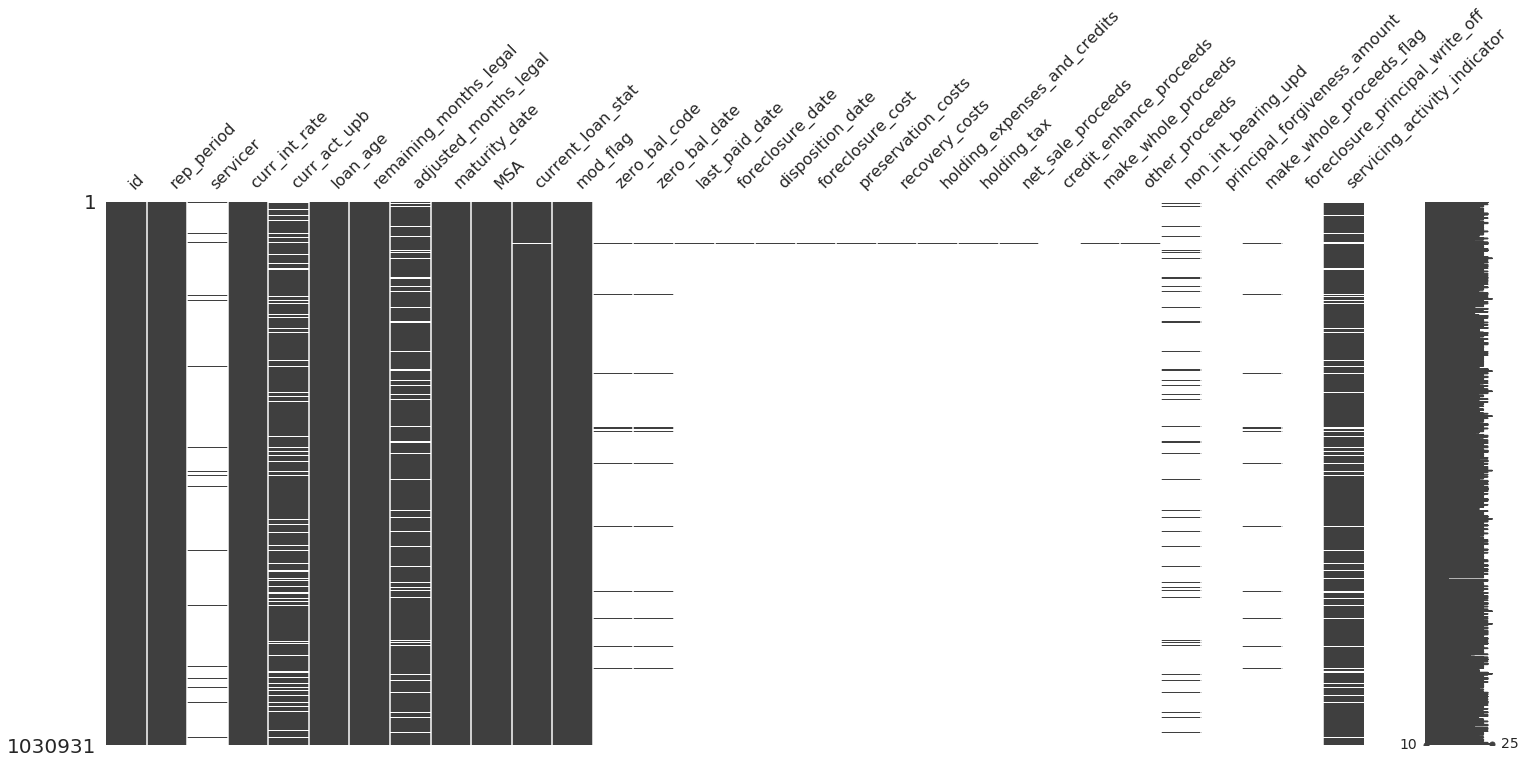

In [11]:
# Visulize missing data in performance table
msno.matrix(perf_exp_df.sample(int(len(perf_df)*0.05)))

Most of the fields are empty in the performance table. This is because many of these fields get populated after the occurrence of a default event (for example, 'recovery_costs','holding_expenses_and_credits' etc). We will thus remove these in our subsequent data processing steps as we only want data available before a default event occurs (like in a real-case scenario). 

In [12]:
# Use id and current loan status
perf_exp_df = perf_exp_df[['id', 'current_loan_stat']]

# Filter to remove nulls in 'current_loan_stat'
perf_exp_df = perf_exp_df[(perf_exp_df['current_loan_stat'].notnull()) & (perf_exp_df['current_loan_stat'] != 'X')]

# With all nulls removed, define the conversion to explore the data with target labels
# As defined previously, we will use the Basel II definition of default (90 days or over without payment)
# This will convert 'current_loan_stat' to a binary field
# Thus, we choose anything with delinquency status of 3 and above as defaulted

perf_exp_df['current_loan_stat'] = perf_exp_df.isin(['0','1','2'])['current_loan_stat'].map({True:0,False:1})

# Group by 'id' to see if a loan defaulted or not
perf_exp_df = perf_exp_df.groupby('id').max()

In [13]:
perf_exp_df.head()

,current_loan_stat
id,
100002296854,0
100006876815,0
100008184591,1
100008870761,1
100013284158,1


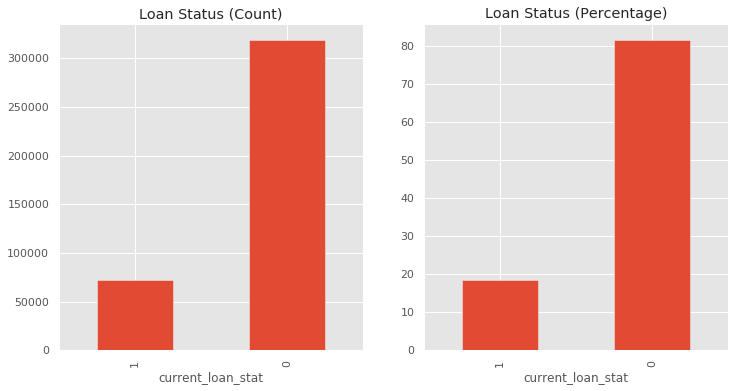

In [14]:
# Visualize the distribution of target labels (default = 1 and non-default = 0)

plt.style.use('ggplot')

fig, ax = plt.subplots(1,2,figsize=(12,6))

(perf_exp_df.groupby('current_loan_stat')['current_loan_stat'].count()
 .sort_values(ascending=True).plot(kind='bar', title='Loan Status (Count)', ax=ax[0]))

# Percentage of target labels
(((perf_exp_df.groupby('current_loan_stat')['current_loan_stat']
   .count()*100/perf_exp_df.count()[0]).sort_values(ascending=True))
   .plot(kind='bar', title='Loan Status (Percentage)', ax=ax[1]))

In [15]:
# Drop unneeded columns
acq_exp_df = acq_exp_df.drop(columns=['orig_channel_A','seller_name_A','orig_loan_term_A',
                                      'orig_date_A','first_pay_date_A','orig_cltv_A',
                                      'borrowers_A','purpose_A','property_type_A','num_of_units_A',
                                      'occupancy_type_A','zip_A','insurance_perc_A',
                                      'product_type_A','co_borrower_credit_score_A','insurance_type_A',
                                      'relocation_A'])

# Join truncated performance and acquisition tables
perf_acq_df = (pd.merge(perf_exp_df, acq_exp_df, left_index=True,right_on=['id_A'], how='inner')
               .drop(columns='id_A'))
perf_acq_df.head()

,current_loan_stat,orig_int_rate_A,orig_upb_A,orig_ltv_A,orig_dtir_A,borrower_credit_score_A,first_time_buyer_A,state_A
0,0,6.625,343000.0,86.0,27.0,751.0,N,CO
1,0,6.250,400000.0,62.0,35.0,804.0,N,CA
2,1,6.625,81000.0,64.0,53.0,585.0,N,LA
3,1,6.500,119000.0,71.0,35.0,646.0,N,IL
4,1,6.625,205000.0,27.0,54.0,591.0,N,CA


In [16]:
perf_acq_df.isnull().mean()

current_loan_stat          0.000000
orig_int_rate_A            0.000003
orig_upb_A                 0.000000
orig_ltv_A                 0.000000
orig_dtir_A                0.029350
borrower_credit_score_A    0.001600
first_time_buyer_A         0.000000
state_A                    0.000000
dtype: float64

In [17]:
# Remove the nulls
perf_acq_df = perf_acq_df[((~perf_acq_df['orig_int_rate_A'].isnull()) & 
                           (~perf_acq_df['orig_dtir_A'].isnull()) & 
                           (~perf_acq_df['borrower_credit_score_A'].isnull()))]

In [18]:
# Bin credit scores
bins = [-float('inf'), 500, 600, 700, 800, float('inf')]
perf_acq_df['binned_credit_scores'] = pd.cut(perf_acq_df['borrower_credit_score_A'], bins)

# Bin interest rates
int_bins = [-float('inf'), 5, 6, 7, 8, 9, float('inf')]
perf_acq_df['binned_int_rate'] = pd.cut(perf_acq_df['orig_int_rate_A'], int_bins, include_lowest=True, right=False)

perf_acq_df.head()

,current_loan_stat,orig_int_rate_A,orig_upb_A,orig_ltv_A,orig_dtir_A,borrower_credit_score_A,first_time_buyer_A,state_A,binned_credit_scores,binned_int_rate
0,0,6.625,343000.0,86.0,27.0,751.0,N,CO,"(700.0, 800.0]","[6.0, 7.0)"
1,0,6.250,400000.0,62.0,35.0,804.0,N,CA,"(800.0, inf]","[6.0, 7.0)"
2,1,6.625,81000.0,64.0,53.0,585.0,N,LA,"(500.0, 600.0]","[6.0, 7.0)"
3,1,6.500,119000.0,71.0,35.0,646.0,N,IL,"(600.0, 700.0]","[6.0, 7.0)"
4,1,6.625,205000.0,27.0,54.0,591.0,N,CA,"(500.0, 600.0]","[6.0, 7.0)"


### Plot 'Interest Rate' vs 'Percentage Defaults from each Category'

Text(0, 0.5, 'Percentage Defaults (%)')

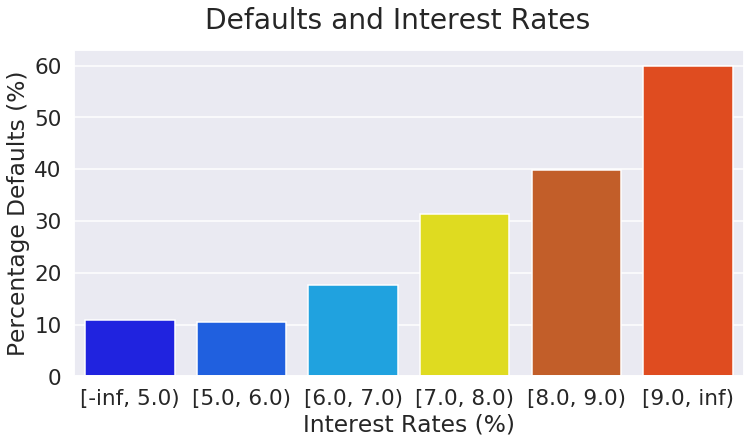

In [19]:
# Set color palette
palette = ['#0004ff','#0055ff','#00aeff','#fffa00','#db560f','#ff3b00']
sns.set_palette(palette)

# Set style and context for font scaling
sns.set_style('darkgrid')
sns.set_context('talk', font_scale=1.3)

# Set figure and axes objects
fig, ax = plt.subplots(figsize=(12,6))

# Calculate defaults vs interest rate
default_count = perf_acq_df[perf_acq_df['current_loan_stat']==1]\
.groupby(['binned_int_rate'])['current_loan_stat']\
.count()*100/perf_acq_df.groupby(['binned_int_rate'])['current_loan_stat'].count()

# Plot data
sns.barplot(x=default_count.index, y=default_count.values, palette=sns.color_palette(), ax=ax)

# Set titles
fig.suptitle('Defaults and Interest Rates')
ax.set_xlabel('Interest Rates (%)')
ax.set_ylabel('Percentage Defaults (%)')

From the above analysis, we can see that as interest rates rise, the percentage of loans defaulting rises. 

### Plot Credit Score vs Percentage Defaults from each Category

Text(0, 0.5, 'Percentage Defaults (%)')

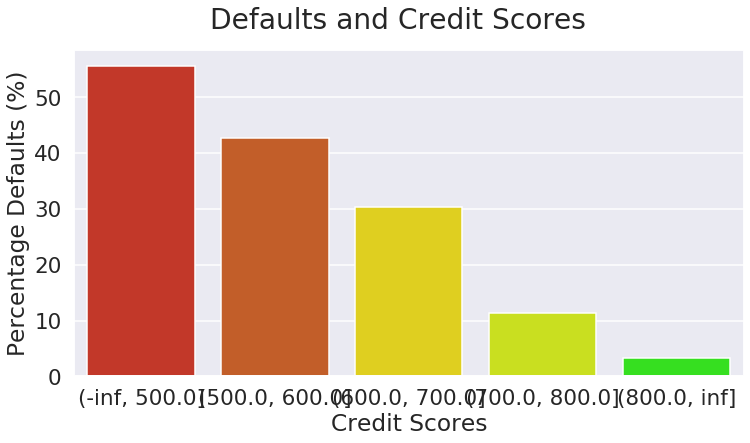

In [20]:
# Set color palette
palette = ['#db230f','#db560f','#ffe900','#e1ff00','#1dff00']
sns.set_palette(palette)

# Set style and context for font scaling
sns.set_style('darkgrid')
sns.set_context('talk', font_scale=1.3)

# Set figure and axes objects
fig, ax = plt.subplots(figsize=(12,6))

# Calculate defaults vs credit score
default_count = perf_acq_df[perf_acq_df['current_loan_stat']==1]\
.groupby(['binned_credit_scores'])['current_loan_stat']\
.count()*100/perf_acq_df.groupby(['binned_credit_scores'])['current_loan_stat'].count()

# Plot data
sns.barplot(x=default_count.index, y=default_count.values, palette=sns.color_palette(), ax=ax)

# Set titles
fig.suptitle('Defaults and Credit Scores')
ax.set_xlabel('Credit Scores')
ax.set_ylabel('Percentage Defaults (%)')

The higher the credit scores, the 'safer' a potential mortgage as lower default rates tend to result, based on the above analysis. 

<h1 align='center'>Features Pre-Processing and Selection</h1>

After data exploration, we can now begin data features pre-processing and selection to get our data into a form that can be ingested for predictive model training and testing.

## Data Cleaning/Munging

In [21]:
# Drop unneeded columns such as dates and those with high missing values
perf_df = perf_df.drop(columns=['non_int_bearing_upd',              # After default
                                'principal_forgiveness_amount',     # After default
                                'servicer',                         # Majority is empty
                                'maturity_date',                    # Not needed
                                'zero_bal_date',                    # After default
                                'last_paid_date',                   # After default
                                'foreclosure_date',                 # After default
                                'disposition_date',                 # After default
                                'foreclosure_cost',                 # After default
                                'preservation_costs',               # After default
                                'recovery_costs',                   # After default
                                'holding_expenses_and_credits',     # After default
                                'holding_tax',                      # After default
                                'net_sale_proceeds',                # After default
                                'credit_enhance_proceeds',          # After default
                                'make_whole_proceeds',              # After default
                                'other_proceeds',                   # After default  
                                'make_whole_proceeds_flag',         # After default
                                'foreclosure_principal_write_off']) # After default

# Filter out those rows that have 'current_loan_stat' as null or X
perf_df = perf_df[(perf_df['current_loan_stat'].notnull()) & (perf_df['current_loan_stat'] != 'X')]

# Define the conversion function for the target labels based on our initial definition (Basel II)
perf_df['current_loan_stat'] = perf_df.isin(['0','1','2'])['current_loan_stat'].map({True:0,False:1})

# Filter out information after a loan's delinquency as in real-case, we only have data before delinquency
# To do this, we first calculate cumulative sum of 'current_loan_stat'
# Then, we filter to take only those at or before the first delinquency
perf_df['cum_loan_stat'] = perf_df.groupby('id')['current_loan_stat'].cumsum()
perf_df = perf_df[perf_df['cum_loan_stat']<=1]

print(perf_df['id'].count())
perf_df.head()

17198651


,id,rep_period,curr_int_rate,curr_act_upb,loan_age,remaining_months_legal,adjusted_months_legal,MSA,current_loan_stat,mod_flag,zero_bal_code,servicing_activity_indicator,cum_loan_stat
0,100002296854,11/01/2007,6.625,NaN,0,360.0,359.0,17820,0,N,NaN,NaN,0
1,100002296854,12/01/2007,6.625,NaN,1,359.0,358.0,17820,0,N,NaN,NaN,0
2,100002296854,01/01/2008,6.625,NaN,2,358.0,357.0,17820,0,N,NaN,NaN,0
3,100002296854,02/01/2008,6.625,NaN,3,357.0,356.0,17820,0,N,NaN,N,0
4,100002296854,03/01/2008,6.625,NaN,4,356.0,355.0,17820,0,N,NaN,N,0


In [22]:
# Convert rep_period to date format (actual format mm/dd/YYYY)
perf_df['rep_period'] = pd.to_datetime(perf_df['rep_period'], infer_datetime_format=True)

# Function to determine quarter

def quarter_func(x):
    if x.month in [1,2,3]:
        return 1
    if x.month in [4,5,6]:
        return 2
    if x.month in [7,8,9]:
        return 3
    else:
        return 4

# Create quarter and year column from 'rep_period'
perf_df.insert(3, 'rep_quarter', perf_df['rep_period'].apply(quarter_func))
perf_df.insert(2, 'rep_year', perf_df['rep_period'].apply(lambda x: x.year))

### Calculation of Custom Features using Original and External Data

The LTV (Loan-to-Value Ratio) at origination theoratically would be an important feature for default prediction; we will augment this by including external house pricing indices from the FHFA [(Federal Housing Finance Agency)](https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index-Datasets.aspx#qpo). 

The idea here is that we want to observe what happens as house prices change over the years of the loan, in relation to the origination loan amounts. In theory, falling house prices will mean higher LTVs, which will likely result in higher default rates as borrowers deem their investments unfeasible to continue paying for. We will thus create a calculated field called **'max_curr_ltv_diff_perc'** that will give the highest LTV a mortgage has experienced over its lifetime. This will be used as a supplementary feature in our predictive models to improve performance.

We will also create another calculated feature called **'diff_in_months'**. This feature will keep track of a loan's payment history before a default event. It is the difference between the 'adjusted_months_legal' and 'remaining_months_legal' fields. If a borrower makes early payments, the 'adjusted_months_legal' field will have a lower value than the 'remaining_months_legal' field, thereby giving a negative value. If a borrower misses a payment, this will become positive. 

The performance table has the 'MSA' field so let's see if we can merge it with the FHFA's metro table, which corresponds to the 'MSA' field. We will first load the FHFA data that corresponds to the MSA field.

In [23]:
fhfa_df = pd.read_excel('/mnt/d/Users/machine_learning_projects/Fannie Mae/FHFA/HPI_PO_metro.xls')
fhfa_df = fhfa_df.drop(columns=['metro_name','index_nsa'])
fhfa_df.head()

,cbsa,yr,qtr,index_sa
0,10420,1991,1,100.00
1,10420,1991,2,101.19
2,10420,1991,3,101.39
3,10420,1991,4,103.07
4,10420,1992,1,104.53


Let's see if all the MSA match up with the codes in FHFA data from above.

In [24]:
# List of MSA in perf_df
perf_msa = perf_df['MSA'].unique().tolist()
print('Number of unique MSA codes in perf_df:', len(perf_msa))

# List of MSA in fhfa_df
fhfa_msa = [str(x) for x in fhfa_df['cbsa'].unique().tolist()]
print('Number of unique MSA codes in FHFA metro file:', len(fhfa_msa))

# Intersection of both lists
msa_int = set(fhfa_msa).intersection(set(perf_msa))
print('Number of intersecting MSA:', len(msa_int))

Number of unique MSA codes in perf_df: 406
Number of unique MSA codes in FHFA metro file: 100
Number of intersecting MSA: 72


Not all the MSA codes are intersecting. This means we will need to use another location field that can match to housing indices. The FHFA provides state-level housing indices as well. This will be used to fill housing index values when the MSA values are unavailable. For now, let's join the metro dataframe with the performance dataframe.

In [25]:
perf_df[['MSA','rep_year','rep_quarter']]

,MSA,rep_year,rep_quarter
0,17820,2007,4
1,17820,2007,4
2,17820,2008,1
3,17820,2008,1
4,17820,2008,1
...,...,...,...
20618542,33100,2008,4
20618543,33100,2008,4
20618544,33100,2009,1
20618545,33100,2009,1


In [26]:
fhfa_df[['cbsa','yr','qtr']]

,cbsa,yr,qtr
0,10420,1991,1
1,10420,1991,2
2,10420,1991,3
3,10420,1991,4
4,10420,1992,1
...,...,...,...
10995,49340,2017,2
10996,49340,2017,3
10997,49340,2017,4
10998,49340,2018,1


In [27]:
[x for x in sorted(perf_df['MSA'].unique()) if x is not None]

['00000',
 '10180',
 '10380',
 '10420',
 '10500',
 '10540',
 '10580',
 '10740',
 '10780',
 '10900',
 '11020',
 '11100',
 '11180',
 '11260',
 '11300',
 '11340',
 '11460',
 '11500',
 '11540',
 '11640',
 '11700',
 '12020',
 '12060',
 '12100',
 '12220',
 '12260',
 '12420',
 '12540',
 '12580',
 '12620',
 '12700',
 '12940',
 '12980',
 '13020',
 '13140',
 '13220',
 '13380',
 '13460',
 '13740',
 '13780',
 '13820',
 '13900',
 '13980',
 '14010',
 '14020',
 '14060',
 '14100',
 '14260',
 '14460',
 '14500',
 '14540',
 '14740',
 '14860',
 '15180',
 '15260',
 '15380',
 '15500',
 '15540',
 '15680',
 '15940',
 '15980',
 '16020',
 '16060',
 '16180',
 '16220',
 '16300',
 '16540',
 '16580',
 '16620',
 '16700',
 '16740',
 '16820',
 '16860',
 '16940',
 '16980',
 '17020',
 '17140',
 '17300',
 '17420',
 '17460',
 '17660',
 '17780',
 '17820',
 '17860',
 '17900',
 '17980',
 '18020',
 '18140',
 '18580',
 '18700',
 '18880',
 '19060',
 '19100',
 '19140',
 '19180',
 '19260',
 '19300',
 '19340',
 '19380',
 '19460',


Given strings such as '00000', we will convert the 'cbsa' column in dataframe 'fhfa_df' to string type. 

In [28]:
fhfa_df['cbsa'] = fhfa_df['cbsa'].astype(str)
fhfa_df.dtypes

cbsa         object
yr            int64
qtr           int64
index_sa    float64
dtype: object

In [29]:
perf_df = pd.merge(perf_df, fhfa_df, left_on=['MSA','rep_year','rep_quarter'],
                        right_on=['cbsa','yr','qtr'], how='left').drop(columns=['cbsa','yr','qtr'])
perf_df.head()

,id,rep_period,rep_year,curr_int_rate,rep_quarter,curr_act_upb,loan_age,remaining_months_legal,adjusted_months_legal,MSA,current_loan_stat,mod_flag,zero_bal_code,servicing_activity_indicator,cum_loan_stat,index_sa
0,100002296854,2007-11-01,2007,6.625,4,NaN,0,360.0,359.0,17820,0,N,NaN,NaN,0,253.28
1,100002296854,2007-12-01,2007,6.625,4,NaN,1,359.0,358.0,17820,0,N,NaN,NaN,0,253.28
2,100002296854,2008-01-01,2008,6.625,1,NaN,2,358.0,357.0,17820,0,N,NaN,NaN,0,248.91
3,100002296854,2008-02-01,2008,6.625,1,NaN,3,357.0,356.0,17820,0,N,NaN,N,0,248.91
4,100002296854,2008-03-01,2008,6.625,1,NaN,4,356.0,355.0,17820,0,N,NaN,N,0,248.91


<br>
Now let's load the state-level housing indices' FHFA file into a dataframe. The source is from the same link at [FHFA's House Price Index Repository](https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index-Datasets.aspx#qpo).
<br>

In [30]:
fhfa_state_df = (pd.read_excel('/mnt/d/Users/machine_learning_projects/Fannie Mae/FHFA/HPI_PO_state.xls')
                 .drop(columns=['index_nsa','Warning']))
fhfa_state_df.head()

,state,yr,qtr,index_sa
0,AK,1991,1,100.00
1,AK,1991,2,99.97
2,AK,1991,3,101.04
3,AK,1991,4,102.04
4,AK,1992,1,102.23


The following two cells calculate the initial stages of the two custom features **'max_curr_ltv_diff_perc'** and **'diff_in_months'**.

In [31]:
# Calculate difference in adjusted and remaining months to see if any pre-payment done
perf_df['all_diff_in_months'] = (perf_df['adjusted_months_legal'] - perf_df['remaining_months_legal'])

# Merge state from acquisition with performance data
perf_df = (pd.merge(perf_df, acq_df[['id_A','state_A']], left_on=['id'],right_on=['id_A'], how='inner')
           .drop(columns=['id_A','adjusted_months_legal','remaining_months_legal','rep_period','curr_act_upb']))

# Now to join with FHFA file (State)
perf_df = pd.merge(perf_df, fhfa_state_df, left_on=['state_A','rep_year','rep_quarter'],
                        right_on=['state','yr','qtr'], how='left')

# List comprehension to get value from index_sa_x, but if nan, get from index_sa_y
perf_df['index_sa'] = [a if ~np.isnan(a) else b for a, b in zip(perf_df['index_sa_x'], 
                            perf_df['index_sa_y'])]

perf_df = perf_df.drop(columns=['index_sa_x','index_sa_y','yr','qtr','state'])

# Join with acq_df to get 'orig_ltv_A'
perf_df = pd.merge(perf_df, acq_df[['id_A','orig_ltv_A']], 
                        left_on=['id'], right_on=['id_A'], how='inner').drop(columns=['id_A'])

In [32]:
# Determine percentage change in housing index using window function
perf_df['loan_group_diff'] = perf_df.groupby('id')['index_sa'].pct_change(periods=1, fill_method='pad')

# Fill NA in 'loan_group_diff' with 1 as the base house index for each id
perf_df['loan_group_diff'] = perf_df['loan_group_diff'].fillna(1)

# Calculate cumulative sum of 'loan_group_diff'
perf_df['cum_index'] = perf_df.groupby('id')['loan_group_diff'].cumsum()

# Calculate current ltv
perf_df['curr_ltv'] = perf_df['orig_ltv_A']/perf_df['cum_index']

# Calculate percentage difference in current ltv from original ltv
perf_df['curr_ltv_diff_perc'] = (perf_df['curr_ltv'] - perf_df['orig_ltv_A'])*100/perf_df['orig_ltv_A']

# This is how final perf_df should look like before joining with acq_df
perf_df = perf_df.drop(columns=['state_A', 'orig_ltv_A', 'loan_group_diff', 'cum_index', 'index_sa', 'curr_ltv'])
perf_df.head()

,id,rep_year,curr_int_rate,rep_quarter,loan_age,MSA,current_loan_stat,mod_flag,zero_bal_code,servicing_activity_indicator,cum_loan_stat,all_diff_in_months,curr_ltv_diff_perc
0,100002296854,2007,6.625,4,0,17820,0,N,NaN,NaN,0,-1.0,0.000000
1,100002296854,2007,6.625,4,1,17820,0,N,NaN,NaN,0,-1.0,0.000000
2,100002296854,2008,6.625,1,2,17820,0,N,NaN,NaN,0,-1.0,1.755655
3,100002296854,2008,6.625,1,3,17820,0,N,NaN,N,0,-1.0,1.755655
4,100002296854,2008,6.625,1,4,17820,0,N,NaN,N,0,-1.0,1.755655


In [33]:
# Check all uniques in dataframe
for x in [column for column in perf_df.columns if column not in ['rep_year','rep_quarter','rep_period','id',
                                                                 'curr_act_upb','curr_int_rate','loan_age',
                                                                 'remaining_months_legal','adjusted_months_legal',
                                                                 'all_diff_in_months','curr_ltv_diff_perc']]:
    print(x,':',perf_df[x].unique())

MSA : ['17820' '41740' '12940' '16980' '31100' '38300' '41180' '38060' '40220'
 '12260' '26580' '14460' '36740' '26420' '35620' '42660' '40140' '00000'
 '16620' '14020' '47900' '45220' '40060' '16220' '33100' '26900' '28140'
 '29460' '33460' '41980' '26300' '14500' '39820' '37980' '47260' '43340'
 '31080' '18140' '27260' '12540' '11700' '39740' '39540' '20260' '22500'
 '13740' '30780' '27740' '17460' '24540' '36260' '46140' '19380' '29820'
 '27620' '12060' '46060' '19780' '21660' '26180' '19740' '43620' '20220'
 '33340' '10580' '44180' '40900' '39580' '39340' '38900' '39660' '29540'
 '37860' '29620' '25420' '35300' '24660' '49180' '36420' '40380' '14260'
 '17900' '41860' '12420' '24340' '10740' '19820' '24420' '19100' '34980'
 '26620' '11500' '25860' '22660' '25980' '12580' '27900' '44700' '41620'
 '17980' '16860' '42340' '26100' '31860' '31140' '49340' '28660' '23540'
 '13460' '10380' '37100' '33260' '39300' '10900' '34820' '31700' '31180'
 '45300' '30460' '22380' '21140' '28700' '349

**Categorical Variables**

We have some interesting categorical variables in the performance table so we will one-hot encode them to transform them to numeric data representative of the categories. This is done using the pandas method of 'get_dummies' as shown below. 

In [34]:
# Dummy variables for 'mod_flag'

n = pd.get_dummies(perf_df['mod_flag'], drop_first=True, prefix='mod_flag')
o = pd.get_dummies(perf_df['servicing_activity_indicator'], drop_first=True, prefix='servicing_activity_indicator',
                   dummy_na=True)
display(n.head())

# Join all after one-hot encoding
perf_df = pd.concat([perf_df,n,o], axis=1).drop(columns=['mod_flag','servicing_activity_indicator'])
display(perf_df.head())

,mod_flag_Y
0,0
1,0
2,0
3,0
4,0


,id,rep_year,curr_int_rate,rep_quarter,loan_age,MSA,current_loan_stat,zero_bal_code,cum_loan_stat,all_diff_in_months,curr_ltv_diff_perc,mod_flag_Y,servicing_activity_indicator_Y,servicing_activity_indicator_nan
0,100002296854,2007,6.625,4,0,17820,0,NaN,0,-1.0,0.000000,0,0,1
1,100002296854,2007,6.625,4,1,17820,0,NaN,0,-1.0,0.000000,0,0,1
2,100002296854,2008,6.625,1,2,17820,0,NaN,0,-1.0,1.755655,0,0,1
3,100002296854,2008,6.625,1,3,17820,0,NaN,0,-1.0,1.755655,0,0,0
4,100002296854,2008,6.625,1,4,17820,0,NaN,0,-1.0,1.755655,0,0,0


Now we group the data by loan ID and aggregate to get our custom features **'max_curr_ltv_diff_perc'** and **'diff_in_months'** along with other aggregated features.

In [35]:
perf_df = (perf_df.groupby('id').agg({'curr_int_rate':['mean','max'],
                                      'loan_age':'mean',
                                      'MSA':'max',
                                      'current_loan_stat':['max'],
                                      'all_diff_in_months':'mean',
                                      'curr_ltv_diff_perc':'max',
                                      'mod_flag_Y':'max',
                                      'servicing_activity_indicator_Y':'max'}))

perf_df.columns = ['mean_curr_int_rate',
                   'max_curr_int_rate',
                   'mean_loan_age','MSA',
                   'max_loan_stat',
                   'diff_in_months',
                   'max_curr_ltv_diff_perc',
                   'mod_flag_Y',
                   'max_servicing_activity_indicator']
perf_df.head()

,mean_curr_int_rate,max_curr_int_rate,mean_loan_age,MSA,max_loan_stat,diff_in_months,max_curr_ltv_diff_perc,mod_flag_Y,max_servicing_activity_indicator
id,,,,,,,,,
100002296854,6.625,6.625,6.5,17820,0,-1.214286,8.583365,0,0
100006876815,6.250,6.250,34.5,41740,0,-0.279412,35.849587,0,0
100008184591,6.625,6.625,21.0,12940,1,0.232558,6.625991,0,1
100008870761,6.500,6.500,48.0,16980,1,-2.736842,28.140203,0,1
100013284158,6.625,6.625,18.0,31100,1,-0.351351,58.055377,0,0


Given the high cardinality of the MSA field and its disordered nature, we map each category in the MSA field to the mean default rate for that particular category. This will transform it to numeric form while preserving its information value. It is similar to 'Leave-One-Out Encoding'.

In [36]:
MSA_map = (perf_df[perf_df['max_loan_stat']==1].groupby('MSA')['max_loan_stat'].count()*100)/len(perf_df)
perf_df['MSA_mapped'] = perf_df['MSA'].map(MSA_map.to_dict())
perf_df = perf_df.drop(columns=['MSA'])
perf_df['MSA_mapped'].head()

id
100002296854    0.025054
100006876815    0.098428
100008184591    0.035536
100008870761    0.999366
100013284158    0.575485
Name: MSA_mapped, dtype: float64

In [37]:
# Merging of both perf_df and acq_df
perf_df = pd.merge(acq_df, perf_df, left_on='id_A', right_index=True, how='inner')
print(perf_df.shape)
display(perf_df.head())

# Checkpoint for new DF
joined_df = perf_df.copy()

(391148, 34)


,id_A,orig_channel_A,seller_name_A,orig_int_rate_A,orig_upb_A,orig_loan_term_A,orig_date_A,first_pay_date_A,orig_ltv_A,orig_cltv_A,borrowers_A,orig_dtir_A,borrower_credit_score_A,first_time_buyer_A,purpose_A,property_type_A,num_of_units_A,occupancy_type_A,state_A,zip_A,insurance_perc_A,product_type_A,co_borrower_credit_score_A,insurance_type_A,relocation_A,mean_curr_int_rate,max_curr_int_rate,mean_loan_age,max_loan_stat,diff_in_months,max_curr_ltv_diff_perc,mod_flag_Y,max_servicing_activity_indicator,MSA_mapped
0,100002296854,C,"BANK OF AMERICA, N.A.",6.625,343000.0,360,10/2007,12/2007,86.0,86.0,2.0,27.0,751.0,N,C,PU,1,P,CO,809,25.0,FRM,756.0,2.0,N,6.625,6.625,6.5,0,-1.214286,8.583365,0,0,0.025054
1,100006876815,C,"BANK OF AMERICA, N.A.",6.250,400000.0,360,10/2007,12/2007,62.0,62.0,2.0,35.0,804.0,N,P,SF,1,P,CA,920,NaN,FRM,790.0,NaN,N,6.250,6.250,34.5,0,-0.279412,35.849587,0,0,0.098428
2,100008184591,B,OTHER,6.625,81000.0,360,11/2007,01/2008,64.0,82.0,1.0,53.0,585.0,N,R,SF,1,P,LA,708,NaN,FRM,NaN,NaN,N,6.625,6.625,21.0,1,0.232558,6.625991,0,1,0.035536
3,100008870761,B,AMTRUST BANK,6.500,119000.0,360,11/2007,01/2008,71.0,71.0,1.0,35.0,646.0,N,R,CO,1,P,IL,600,NaN,FRM,NaN,NaN,N,6.500,6.500,48.0,1,-2.736842,28.140203,0,1,0.999366
4,100013284158,B,"BANK OF AMERICA, N.A.",6.625,205000.0,360,10/2007,12/2007,27.0,27.0,1.0,54.0,591.0,N,C,SF,1,P,CA,907,NaN,FRM,NaN,NaN,N,6.625,6.625,18.0,1,-0.351351,58.055377,0,0,0.575485


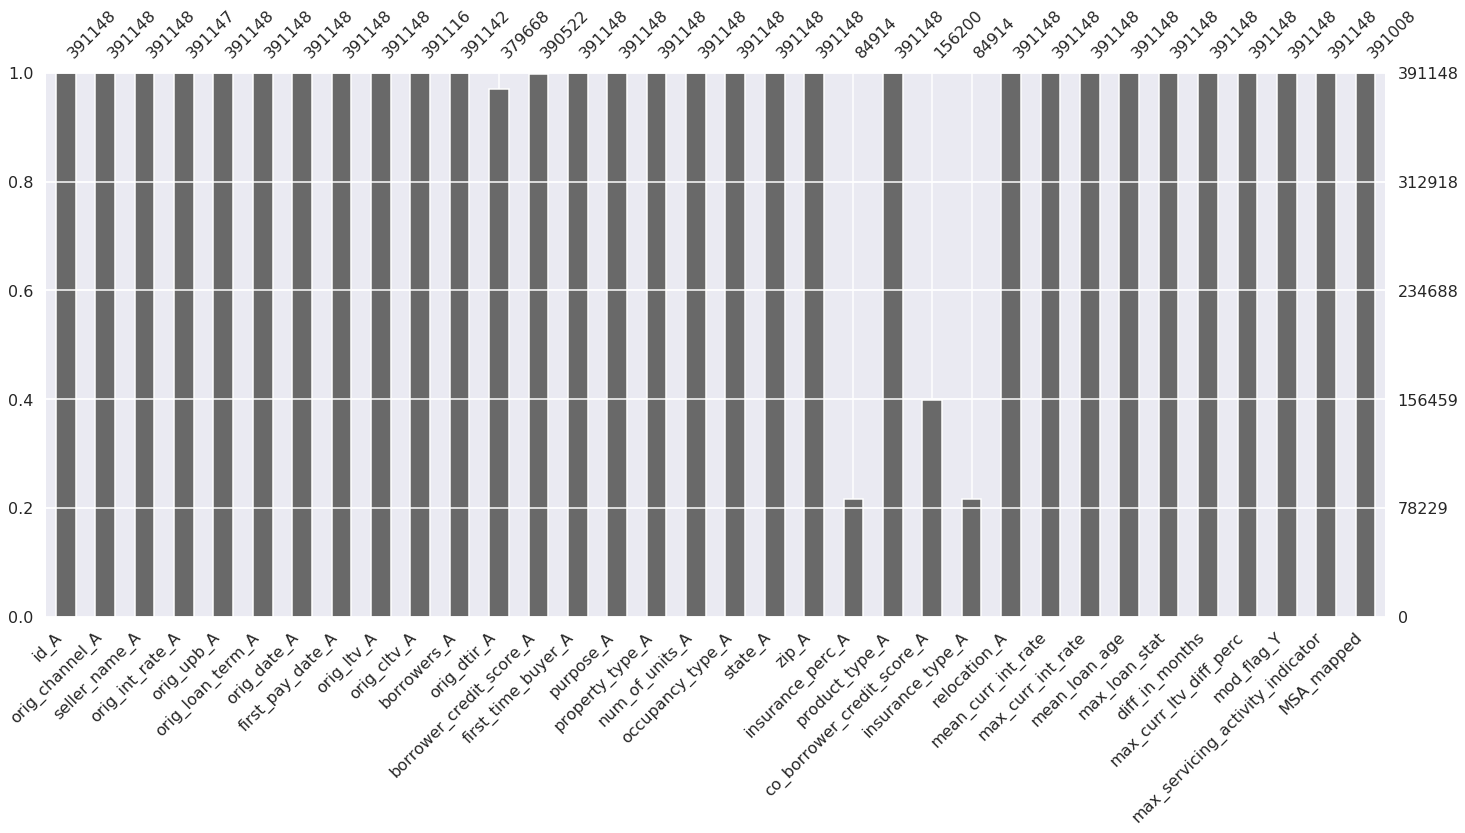

In [38]:
# Plot bar chart of missing data in joined table
msno.bar(joined_df)

In [39]:
# Drop columns from joined_df (dates and those with lots of nulls)
joined_df = joined_df.drop(columns=['orig_date_A',                # Date
                                    'first_pay_date_A',           # Date
                                    'orig_cltv_A',                # 99% empty
                                    'insurance_perc_A',           # 78% empty
                                    'co_borrower_credit_score_A', # 60% empty
                                    'product_type_A'])            # only 'FRM' product

In [40]:
# Check columns with nulls
null_cols = joined_df.isnull().mean()
null_cols[null_cols > 0]

orig_int_rate_A            0.000003
borrowers_A                0.000015
orig_dtir_A                0.029350
borrower_credit_score_A    0.001600
insurance_type_A           0.782911
MSA_mapped                 0.000358
dtype: float64

In [41]:
# Drop nulls in 'orig_int_rate_A' (very low percentage so no issue)
joined_df = joined_df[(joined_df['orig_int_rate_A'].notnull()) & (joined_df['MSA_mapped'].notnull())]

# Impute null values
joined_df['borrowers_A'] = joined_df['borrowers_A'].fillna(joined_df['borrowers_A'].mean())
joined_df['orig_dtir_A'] = joined_df['orig_dtir_A'].fillna(joined_df['orig_dtir_A'].mean())
joined_df['borrower_credit_score_A'] = (joined_df['borrower_credit_score_A']
                                        .fillna(joined_df['borrower_credit_score_A'].mean()))

In [42]:
# Check all uniques in dataframe

col_exc = ['id_A','orig_int_rate_A','orig_upb_A',
           'orig_ltv_A','borrowers_A','orig_dtir_A',
           'borrower_credit_score_A','mean_curr_int_rate',
           'orig_loan_term_A','max_curr_int_rate',
           'mean_loan_age','diff_in_months',
           'max_curr_ltv_diff_perc','MSA_mapped',
           'rep_year','rep_quarter','rep_period','id',
           'curr_act_upb','curr_int_rate','loan_age',
           'remaining_months_legal','adjusted_months_legal',
           'all_diff_in_months','curr_ltv_diff_perc']

for x in [column for column in joined_df.columns if column not in col_exc]:
    print(x,':',joined_df[x].unique())

orig_channel_A : ['C' 'B' 'R']
seller_name_A : ['BANK OF AMERICA, N.A.' 'OTHER' 'AMTRUST BANK' 'PNC BANK, N.A.'
 'JPMORGAN CHASE BANK, NATIONAL ASSOCIATION' 'SUNTRUST MORTGAGE INC.'
 'FIRST TENNESSEE BANK NATIONAL ASSOCIATION' 'WELLS FARGO BANK, N.A.'
 'FLAGSTAR CAPITAL MARKETS CORPORATION'
 'FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB' 'CITIMORTGAGE, INC.'
 'GMAC MORTGAGE, LLC' 'CHASE HOME FINANCE, LLC'
 'HSBC BANK USA, NATIONAL ASSOCIATION']
first_time_buyer_A : ['N' 'Y' 'U']
purpose_A : ['C' 'P' 'R']
property_type_A : ['PU' 'SF' 'CO' 'MH' 'CP']
num_of_units_A : ['1' '2' '4' '3']
occupancy_type_A : ['P' 'I' 'S']
state_A : ['CO' 'CA' 'LA' 'IL' 'PA' 'MO' 'AZ' 'IN' 'VA' 'SC' 'WV' 'MA' 'FL' 'TX'
 'NY' 'WA' 'MD' 'WY' 'KS' 'NM' 'MN' 'PR' 'AR' 'OH' 'NH' 'NC' 'ME' 'WI'
 'MT' 'TN' 'DE' 'UT' 'IA' 'OK' 'NJ' 'NV' 'GA' 'OR' 'HI' 'SD' 'MI' 'CT'
 'NE' 'ID' 'AL' 'KY' 'RI' 'DC' 'MS' 'VT' 'ND' 'AK' 'VI' 'GU']
zip_A : ['809' '920' '708' '600' '907' '160' '605' '631' '601' '850' '464' '240'
 '298' '257' '0

**Categorical Variables**

The acquisition table has many more categorical variables so we will one-hot encode them to transform them to numeric data representative of the categories as shown below.  

In [43]:
# One-hot encode categorical variables

a = pd.get_dummies(joined_df['first_time_buyer_A'], prefix='first_time')
b = pd.get_dummies(joined_df['purpose_A'], prefix='purpose_A')
c = pd.get_dummies(joined_df['property_type_A'], prefix='property_type_A')
d = pd.get_dummies(joined_df['occupancy_type_A'], prefix='occupancy_type_A')
e = pd.get_dummies(joined_df['state_A'], prefix='state_A')
f = pd.get_dummies(joined_df['relocation_A'], prefix='relocation_A', drop_first=True)
g = pd.get_dummies(joined_df['seller_name_A'], prefix='seller_name_A')
h = pd.get_dummies(joined_df['insurance_type_A'], prefix='insurance_type_A', dummy_na=True)
i = pd.get_dummies(joined_df['orig_channel_A'], prefix='orig_channel_A')
a.head()

,first_time_N,first_time_U,first_time_Y
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [44]:
# Join all into one table after one-hot encoding
joined_df_concat = pd.concat([joined_df, a,b,c,d,e,f,g,h,i], axis=1)
joined_df_concat = joined_df_concat.drop(columns=['id_A',
                                                  'seller_name_A',
                                                  'first_time_buyer_A',
                                                  'purpose_A',
                                                  'property_type_A',
                                                  'occupancy_type_A',
                                                  'state_A',
                                                  'relocation_A',
                                                  'insurance_type_A',
                                                  'orig_channel_A'])

# Convert fields to numeric data types
# Zip codes have a geographic order to them so directly changed to integers
joined_df_concat['num_of_units_A'] = joined_df_concat['num_of_units_A'].astype('int64')
joined_df_concat['zip_A'] = joined_df_concat['zip_A'].astype('int64')
joined_df_concat.head()

,orig_int_rate_A,orig_upb_A,orig_loan_term_A,orig_ltv_A,borrowers_A,orig_dtir_A,borrower_credit_score_A,num_of_units_A,zip_A,mean_curr_int_rate,max_curr_int_rate,mean_loan_age,max_loan_stat,diff_in_months,max_curr_ltv_diff_perc,mod_flag_Y,max_servicing_activity_indicator,MSA_mapped,first_time_N,first_time_U,first_time_Y,purpose_A_C,purpose_A_P,purpose_A_R,property_type_A_CO,property_type_A_CP,property_type_A_MH,property_type_A_PU,property_type_A_SF,occupancy_type_A_I,occupancy_type_A_P,occupancy_type_A_S,state_A_AK,state_A_AL,state_A_AR,state_A_AZ,state_A_CA,state_A_CO,state_A_CT,state_A_DC,state_A_DE,state_A_FL,state_A_GA,state_A_GU,state_A_HI,state_A_IA,state_A_ID,state_A_IL,state_A_IN,state_A_KS,...,state_A_MO,state_A_MS,state_A_MT,state_A_NC,state_A_ND,state_A_NE,state_A_NH,state_A_NJ,state_A_NM,state_A_NV,state_A_NY,state_A_OH,state_A_OK,state_A_OR,state_A_PA,state_A_PR,state_A_RI,state_A_SC,state_A_SD,state_A_TN,state_A_TX,state_A_UT,state_A_VA,state_A_VI,state_A_VT,state_A_WA,state_A_WI,state_A_WV,state_A_WY,relocation_A_Y,seller_name_A_AMTRUST BANK,"seller_name_A_BANK OF AMERICA, N.A.","seller_name_A_CHASE HOME FINANCE, LLC","seller_name_A_CITIMORTGAGE, INC.","seller_name_A_FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB",seller_name_A_FIRST TENNESSEE BANK NATIONAL ASSOCIATION,seller_name_A_FLAGSTAR CAPITAL MARKETS CORPORATION,"seller_name_A_GMAC MORTGAGE, LLC","seller_name_A_HSBC BANK USA, NATIONAL ASSOCIATION","seller_name_A_JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",seller_name_A_OTHER,"seller_name_A_PNC BANK, N.A.",seller_name_A_SUNTRUST MORTGAGE INC.,"seller_name_A_WELLS FARGO BANK, N.A.",insurance_type_A_1.0,insurance_type_A_2.0,insurance_type_A_nan,orig_channel_A_B,orig_channel_A_C,orig_channel_A_R
0,6.625,343000.0,360,86.0,2.0,27.0,751.0,1,809,6.625,6.625,6.5,0,-1.214286,8.583365,0,0,0.025054,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,6.250,400000.0,360,62.0,2.0,35.0,804.0,1,920,6.250,6.250,34.5,0,-0.279412,35.849587,0,0,0.098428,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,6.625,81000.0,360,64.0,1.0,53.0,585.0,1,708,6.625,6.625,21.0,1,0.232558,6.625991,0,1,0.035536,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
3,6.500,119000.0,360,71.0,1.0,35.0,646.0,1,600,6.500,6.500,48.0,1,-2.736842,28.140203,0,1,0.999366,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,6.625,205000.0,360,27.0,1.0,54.0,591.0,1,907,6.625,6.625,18.0,1,-0.351351,58.055377,0,0,0.575485,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [45]:
# Assign to X and Y
X = joined_df_concat[[x for x in joined_df_concat.columns if x != 'max_loan_stat']]
y = joined_df_concat['max_loan_stat']
X.head()

,orig_int_rate_A,orig_upb_A,orig_loan_term_A,orig_ltv_A,borrowers_A,orig_dtir_A,borrower_credit_score_A,num_of_units_A,zip_A,mean_curr_int_rate,max_curr_int_rate,mean_loan_age,diff_in_months,max_curr_ltv_diff_perc,mod_flag_Y,max_servicing_activity_indicator,MSA_mapped,first_time_N,first_time_U,first_time_Y,purpose_A_C,purpose_A_P,purpose_A_R,property_type_A_CO,property_type_A_CP,property_type_A_MH,property_type_A_PU,property_type_A_SF,occupancy_type_A_I,occupancy_type_A_P,occupancy_type_A_S,state_A_AK,state_A_AL,state_A_AR,state_A_AZ,state_A_CA,state_A_CO,state_A_CT,state_A_DC,state_A_DE,state_A_FL,state_A_GA,state_A_GU,state_A_HI,state_A_IA,state_A_ID,state_A_IL,state_A_IN,state_A_KS,state_A_KY,...,state_A_MO,state_A_MS,state_A_MT,state_A_NC,state_A_ND,state_A_NE,state_A_NH,state_A_NJ,state_A_NM,state_A_NV,state_A_NY,state_A_OH,state_A_OK,state_A_OR,state_A_PA,state_A_PR,state_A_RI,state_A_SC,state_A_SD,state_A_TN,state_A_TX,state_A_UT,state_A_VA,state_A_VI,state_A_VT,state_A_WA,state_A_WI,state_A_WV,state_A_WY,relocation_A_Y,seller_name_A_AMTRUST BANK,"seller_name_A_BANK OF AMERICA, N.A.","seller_name_A_CHASE HOME FINANCE, LLC","seller_name_A_CITIMORTGAGE, INC.","seller_name_A_FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB",seller_name_A_FIRST TENNESSEE BANK NATIONAL ASSOCIATION,seller_name_A_FLAGSTAR CAPITAL MARKETS CORPORATION,"seller_name_A_GMAC MORTGAGE, LLC","seller_name_A_HSBC BANK USA, NATIONAL ASSOCIATION","seller_name_A_JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",seller_name_A_OTHER,"seller_name_A_PNC BANK, N.A.",seller_name_A_SUNTRUST MORTGAGE INC.,"seller_name_A_WELLS FARGO BANK, N.A.",insurance_type_A_1.0,insurance_type_A_2.0,insurance_type_A_nan,orig_channel_A_B,orig_channel_A_C,orig_channel_A_R
0,6.625,343000.0,360,86.0,2.0,27.0,751.0,1,809,6.625,6.625,6.5,-1.214286,8.583365,0,0,0.025054,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,6.250,400000.0,360,62.0,2.0,35.0,804.0,1,920,6.250,6.250,34.5,-0.279412,35.849587,0,0,0.098428,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,6.625,81000.0,360,64.0,1.0,53.0,585.0,1,708,6.625,6.625,21.0,0.232558,6.625991,0,1,0.035536,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
3,6.500,119000.0,360,71.0,1.0,35.0,646.0,1,600,6.500,6.500,48.0,-2.736842,28.140203,0,1,0.999366,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,6.625,205000.0,360,27.0,1.0,54.0,591.0,1,907,6.625,6.625,18.0,-0.351351,58.055377,0,0,0.575485,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [46]:
# Processed data attributes
print('Total loans:', Counter(y)[0]+Counter(y)[1])
print('Number of non-delinquent loans:', Counter(y)[0])
print('Number of delinquent loans:', Counter(y)[1])
print('Percentage of delinquent loans: {:.2f}%'.format(Counter(y)[1]*100/(Counter(y)[0]+Counter(y)[1])))

Total loans: 391007
Number of non-delinquent loans: 319040
Number of delinquent loans: 71967
Percentage of delinquent loans: 18.41%


<center><h1>Model Training and Testing</h1></center>
<br>
<br>
With the data prepared for ingestion, we can now begin training and testing of our models. We will utilize 3-folds cross-validation for our hyper parameters and will be using the following algorithms:
1. Logistic Regression
2. Random Forest
3. XGBoost

In [47]:
# Split into train and test sets with stratify to ensure same ratio of labels in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10, stratify=y)

# Check split shape
print('Original')
print(X.shape)
print(y.shape)

print('X_train')
print(X_train.shape)

print('X_test')
print(X_test.shape)

print('y_train')
print(y_train.shape)

print('y_test')
print(y_test.shape)
print('')

display(X_train.head())

Original
(391007, 106)
(391007,)
X_train
(293255, 106)
X_test
(97752, 106)
y_train
(293255,)
y_test
(97752,)



,orig_int_rate_A,orig_upb_A,orig_loan_term_A,orig_ltv_A,borrowers_A,orig_dtir_A,borrower_credit_score_A,num_of_units_A,zip_A,mean_curr_int_rate,max_curr_int_rate,mean_loan_age,diff_in_months,max_curr_ltv_diff_perc,mod_flag_Y,max_servicing_activity_indicator,MSA_mapped,first_time_N,first_time_U,first_time_Y,purpose_A_C,purpose_A_P,purpose_A_R,property_type_A_CO,property_type_A_CP,property_type_A_MH,property_type_A_PU,property_type_A_SF,occupancy_type_A_I,occupancy_type_A_P,occupancy_type_A_S,state_A_AK,state_A_AL,state_A_AR,state_A_AZ,state_A_CA,state_A_CO,state_A_CT,state_A_DC,state_A_DE,state_A_FL,state_A_GA,state_A_GU,state_A_HI,state_A_IA,state_A_ID,state_A_IL,state_A_IN,state_A_KS,state_A_KY,...,state_A_MO,state_A_MS,state_A_MT,state_A_NC,state_A_ND,state_A_NE,state_A_NH,state_A_NJ,state_A_NM,state_A_NV,state_A_NY,state_A_OH,state_A_OK,state_A_OR,state_A_PA,state_A_PR,state_A_RI,state_A_SC,state_A_SD,state_A_TN,state_A_TX,state_A_UT,state_A_VA,state_A_VI,state_A_VT,state_A_WA,state_A_WI,state_A_WV,state_A_WY,relocation_A_Y,seller_name_A_AMTRUST BANK,"seller_name_A_BANK OF AMERICA, N.A.","seller_name_A_CHASE HOME FINANCE, LLC","seller_name_A_CITIMORTGAGE, INC.","seller_name_A_FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB",seller_name_A_FIRST TENNESSEE BANK NATIONAL ASSOCIATION,seller_name_A_FLAGSTAR CAPITAL MARKETS CORPORATION,"seller_name_A_GMAC MORTGAGE, LLC","seller_name_A_HSBC BANK USA, NATIONAL ASSOCIATION","seller_name_A_JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",seller_name_A_OTHER,"seller_name_A_PNC BANK, N.A.",seller_name_A_SUNTRUST MORTGAGE INC.,"seller_name_A_WELLS FARGO BANK, N.A.",insurance_type_A_1.0,insurance_type_A_2.0,insurance_type_A_nan,orig_channel_A_B,orig_channel_A_C,orig_channel_A_R
123104,6.250,78000.0,360,49.0,1.0,34.0,656.0,1,605,6.250,6.250,26.0,0.102041,30.983060,0,0,0.999366,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
261065,6.375,82000.0,360,74.0,1.0,51.0,754.0,1,486,6.375,6.375,30.0,-4.593220,29.008156,0,0,1.815937,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
369349,6.125,111000.0,240,88.0,2.0,15.0,668.0,1,405,6.125,6.125,15.5,0.000000,3.146844,0,0,0.015084,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
276656,6.250,400000.0,360,74.0,2.0,44.0,751.0,3,71,6.250,6.250,7.5,-0.125000,10.201166,0,0,0.908096,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
248393,6.375,125000.0,360,55.0,2.0,53.0,679.0,1,973,6.375,6.375,12.5,-0.038462,20.757652,0,0,1.815937,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


Here we define all machine learning algorithm functions along with their respective evaluation metrics.

In [48]:
# Standardizing Function

def standardizer(X_train, X_test):
    
    sc = StandardScaler()
    sc_fitted = sc.fit(X_train)
    
    X_train_std = sc_fitted.transform(X_train)
    X_test_std = sc_fitted.transform(X_test)
    
    return X_train_std, X_test_std

In [49]:
# Confusion Matrix Function

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.style.use('ggplot')
    # Font Size
    SMALL = 12
    MEDIUM = 16
    BIG = 22
    LARGEST = 40
    
    plt.rc('font', size=BIG)             # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM)    # fontsize of the tick labels
    plt.rc('legend', fontsize=BIG)       # legend fontsize
    plt.rc('figure', titlesize=LARGEST)  # fontsize of the figure title
    rcParams['axes.titlepad'] = 20       # increase padding on title
    
    if normalize==True:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.grid(False)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [50]:
# Testing Metrics Function

def metrics(y_train, y_train_pred, y_test, y_test_pred):
    
    print('Train Set Scores')
    print('Accuracy score:', accuracy_score(y_train, y_train_pred))
    print('f1_score:', f1_score(y_train, y_train_pred))
    print('')
    print(classification_report(y_train, y_train_pred))
    print(confusion_matrix(y_train, y_train_pred))

    print('')
    print('Test Set Scores')
    print('Accuracy score:', accuracy_score(y_test, y_test_pred))
    print('f1_score:', f1_score(y_test, y_test_pred, average='binary'))
    print('')
    print(classification_report(y_test, y_test_pred))
    print(confusion_matrix(y_test, y_test_pred))
        
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_test_pred)
    np.set_printoptions(precision=2)

    class_names = list(range(2))
    
    # Plot non-normalized confusion matrix
    plt.figure(figsize=(6,6))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False)
    plt.show()
    
    # Plot non-normalized confusion matrix
    plt.figure(figsize=(6,6))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
    plt.show()

In [51]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
# Feature Importance Function

def feat_imp(model):
    plt.style.use('ggplot')
    # Font Size
    SMALL = 12
    MEDIUM = 16
    BIG = 22
    LARGEST = 40
    
    plt.rc('font', size=BIG)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM)    # legend fontsize
    plt.rc('figure', titlesize=LARGEST)  # fontsize of the figure title
    rcParams['axes.titlepad'] = 20   # increase padding on title
    
    try:
        importances = model.feature_importances_
    except:
        importances = model.best_estimator_.feature_importances_
        
    print('Shape of feature importance vector: ', importances.shape)

    # Plot top 10 most important features
    main_features_df = pd.DataFrame(data=importances, index = X_train.columns, columns=['Importance'])\
                       .sort_values(by='Importance', ascending=False)
    
    main_features_df.iloc[:10].plot.bar(figsize=(15,7), zorder=3, color='green')
    plt.grid(zorder=0)
    plt.ylabel('Relative Importance')

In [53]:
# AUC of ROC Function

def auc(model, X_test, y_test, y_test_pred):
    plt.style.use('ggplot')
    try:
        fpr, tpr, thresholds = roc_curve(y_test,model.predict_proba(X_test)[:,1])
        roc_auc = roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
    except:
        fpr, tpr, thresholds = roc_curve(y_test,model.best_estimator_.predict_proba(X_test)[:,1])
        roc_auc = roc_auc_score(y_test,model.best_estimator_.predict_proba(X_test)[:,1])
    
    figure(figsize=(6,6))
    plt.grid(True)
    plt.plot(fpr, tpr, lw=3, label='AUC = %0.2f'%(roc_auc),color='blue')
    plt.plot([0, 1], [0, 1], '--k', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC Curve')
    plt.legend(loc='lower right', frameon = True).get_frame().set_edgecolor('black')

In [54]:
# Logistic Regression Function with Cross-Validation

def lg_func(CV, params, n_iter, X_train, X_test, y_train, y_test):
    
    # Standardize X_train and X_test
    X_train, X_test = standardizer(X_train, X_test)
    
    model = LogisticRegression()
    
    grid = RandomizedSearchCV(model, params, cv = CV, scoring='f1', n_iter=n_iter)
    grid.fit(X_train, y_train)
    
    print('Best parameters using f1: ', grid.best_params_)
    print('')
    print('Grid Scores:\n')

    params = grid.cv_results_['params']
    means = grid.cv_results_['mean_test_score']
    std = grid.cv_results_['std_test_score']

    for mean, std, param in zip(means, std, params):
        print('Mean is {:.3f} std is {:.3f} and params are {}'.format(mean, std, param))

    y_train_pred = grid.predict(X_train)
    y_test_pred = grid.predict(X_test)
    print('')
    
    # Tuning of model thresholds to find best threshold
    y_test_prob = grid.predict_proba(X_test)[:,1]

    best_f1 = 0
    best_thres = 0.01

    for threshold in np.linspace(0.1,0.9,9):

        print('Threshold is {:.1f}'.format(threshold))
        y_test_thres = [1 if x>=threshold else 0 for x in y_test_prob]

        new_f1 = f1_score(y_test,y_test_thres)
        print('Current f1_score is {:.3f}\n'.format(new_f1))

        if new_f1 > best_f1:
            best_thres = threshold
            best_f1 = new_f1

    print('The best f1_score is {:.3f} and the best threshold is {:.1f}'.format(best_f1,best_thres))

    # Using the best threshold
    y_test_thres = [1 if x>=best_thres else 0 for x in y_test_prob]

    # Print testing metrics
    metrics(y_train,y_train_pred,y_test,y_test_thres)
    
    # Get feature importances
    try:
        feat_imp(grid)
    except:
        print('Cannot get feature importance.')
    
    # Get AUC Curve
    auc(grid, X_test, y_test, y_test_pred)
    
    return grid.best_estimator_

In [55]:
# Random Forest Function with Cross-Validation

def rf_func(CV, params, n_iter, X_train, X_test, y_train, y_test):
    
    # Standardize X_train and X_test
    X_train, X_test = standardizer(X_train, X_test)
    
    model = RandomForestClassifier()
    
    grid = RandomizedSearchCV(model, params, cv = CV, scoring='f1', n_iter=n_iter)
    grid.fit(X_train, y_train)
    
    # Print hyperparameter tuning results
    print('Best parameters using f1: ', grid.best_params_)
    print('')
    print('Grid Scores:\n')

    params = grid.cv_results_['params']
    means = grid.cv_results_['mean_test_score']
    std = grid.cv_results_['std_test_score']

    for mean, std, param in zip(means, std, params):
        print('Mean is {:.3f} std is {:.3f} and params are {}'.format(mean, std, param))

    y_train_pred = grid.predict(X_train)
    y_test_pred = grid.predict(X_test)
    print('')
    
    # Tuning of model thresholds to find best threshold
    y_test_prob = grid.predict_proba(X_test)[:,1]

    best_f1 = 0
    best_thres = 0.01

    for threshold in np.linspace(0.1,0.9,9):

        print('Threshold is {:.1f}'.format(threshold))
        y_test_thres = [1 if x>=threshold else 0 for x in y_test_prob]

        new_f1 = f1_score(y_test,y_test_thres)
        print('Current f1_score is {:.3f}\n'.format(new_f1))

        if new_f1 > best_f1:
            best_thres = threshold
            best_f1 = new_f1

    print('The best f1_score is {:.3f} and the best threshold is {:.1f}'.format(best_f1,best_thres))

    # Using the best threshold
    y_test_thres = [1 if x>=best_thres else 0 for x in y_test_prob]

    # Print testing metrics
    metrics(y_train,y_train_pred,y_test,y_test_thres)
    
    # Get feature importances
    feat_imp(grid)
    
    # Get AUC Curve
    auc(grid, X_test, y_test, y_test_pred)
    
    return grid.best_estimator_

In [56]:
# XGBoost with Cross-Validation

def xgb_func(CV, params, n_iter, X_train, X_test, y_train, y_test):
    
    # Standardize X_train and X_test
    X_train, X_test = standardizer(X_train, X_test)
    
    model = xgb.XGBClassifier()
    
    grid = RandomizedSearchCV(model, params, cv = CV, scoring='f1', n_iter=n_iter)
    grid.fit(X_train, y_train)
    
    print('Best parameters using f1: ', grid.best_params_)
    print('')
    print('Grid Scores:\n')

    params = grid.cv_results_['params']
    means = grid.cv_results_['mean_test_score']
    std = grid.cv_results_['std_test_score']

    for mean, std, param in zip(means, std, params):
        print('Mean is {:.3f} std is {:.3f} and params are {}'.format(mean, std, param))

    y_train_pred = grid.predict(X_train)
    y_test_pred = grid.predict(X_test)
    print('')
    
    # Tuning of model thresholds to find best threshold
    y_test_prob = grid.predict_proba(X_test)[:,1]

    best_f1 = 0
    best_thres = 0.01

    for threshold in np.linspace(0.1,0.9,9):

        print('Threshold is {:.1f}'.format(threshold))
        y_test_thres = [1 if x>=threshold else 0 for x in y_test_prob]

        new_f1 = f1_score(y_test,y_test_thres)
        print('Current f1_score is {:.3f}\n'.format(new_f1))

        if new_f1 > best_f1:
            best_thres = threshold
            best_f1 = new_f1

    print('The best f1_score is {:.3f} and the best threshold is {:.1f}'.format(best_f1,best_thres))

    # Using the best threshold
    y_test_thres = [1 if x>=best_thres else 0 for x in y_test_prob]

    # Print testing metrics
    metrics(y_train,y_train_pred,y_test,y_test_thres)
    
    # Get feature importances
    feat_imp(grid)
    
    # Get AUC Curve
    auc(grid, X_test, y_test, y_test_pred)
    
    return grid.best_estimator_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   27.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   22.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   21.3s finished


[LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


max_iter reached after 34 seconds
Best parameters using f1:  {'verbose': 1, 'solver': 'sag', 'n_jobs': -1, 'class_weight': 'balanced', 'C': 100}

Grid Scores:

Mean is 0.532 std is 0.001 and params are {'verbose': 1, 'solver': 'sag', 'n_jobs': -1, 'class_weight': 'balanced', 'C': 100}
Mean is 0.532 std is 0.001 and params are {'verbose': 1, 'solver': 'liblinear', 'n_jobs': -1, 'class_weight': 'balanced', 'C': 0.1}

Threshold is 0.1


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   33.9s finished


Current f1_score is 0.359

Threshold is 0.2
Current f1_score is 0.410

Threshold is 0.3
Current f1_score is 0.457

Threshold is 0.4
Current f1_score is 0.498

Threshold is 0.5
Current f1_score is 0.530

Threshold is 0.6
Current f1_score is 0.549

Threshold is 0.7
Current f1_score is 0.538

Threshold is 0.8
Current f1_score is 0.463

Threshold is 0.9
Current f1_score is 0.249

The best f1_score is 0.549 and the best threshold is 0.6
Train Set Scores
Accuracy score: 0.7492625871681642
f1_score: 0.531763417305586

              precision    recall  f1-score   support

           0       0.94      0.74      0.83    239280
           1       0.41      0.77      0.53     53975

    accuracy                           0.75    293255
   macro avg       0.67      0.76      0.68    293255
weighted avg       0.84      0.75      0.77    293255

[[177972  61308]
 [ 12222  41753]]

Test Set Scores
Accuracy score: 0.7965361322530485
f1_score: 0.549339496521877

              precision    recall  f1-sc

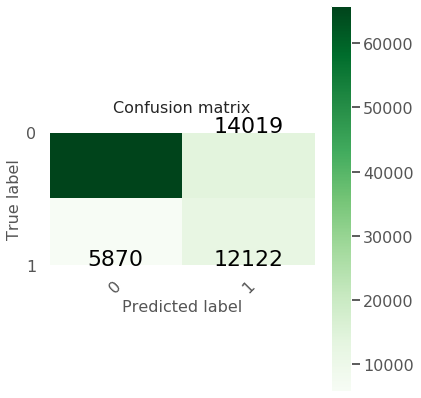

Normalized confusion matrix
[[0.82 0.18]
 [0.33 0.67]]


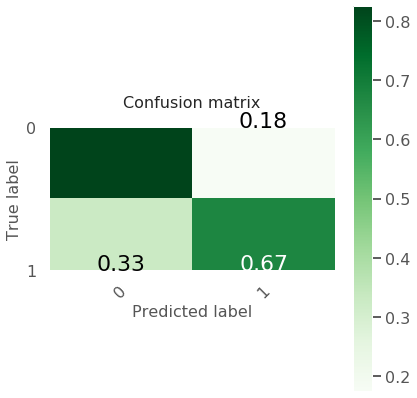

Cannot get feature importance.


LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=1,
                   warm_start=False)

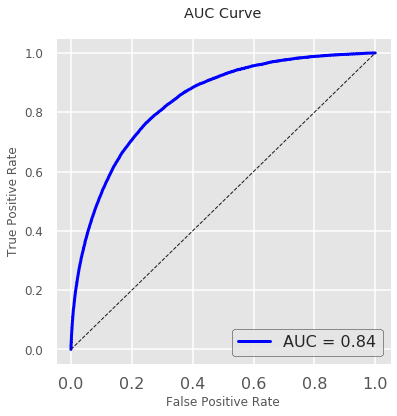

In [57]:
# RandomizedSearchCV - Logistic Regression
# Train, cross-validate (3-folds) and test

c = [0.1,1,10,100,1000]
solver = ['liblinear', 'sag']

lg_params = {'C':c,'verbose':[1],'class_weight':['balanced'],'solver':solver,'n_jobs':[-1]}

lg_func(3, lg_params, 2, X_train, X_test, y_train, y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   28.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   27.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | e

Best parameters using f1:  {'verbose': 1, 'n_jobs': -1, 'n_estimators': 200, 'max_depth': 30, 'criterion': 'entropy', 'class_weight': 'balanced'}

Grid Scores:

Mean is 0.776 std is 0.002 and params are {'verbose': 1, 'n_jobs': -1, 'n_estimators': 200, 'max_depth': 30, 'criterion': 'entropy', 'class_weight': 'balanced'}
Mean is 0.775 std is 0.001 and params are {'verbose': 1, 'n_jobs': -1, 'n_estimators': 100, 'max_depth': 30, 'criterion': 'entropy', 'class_weight': 'balanced'}


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.4s finished


Threshold is 0.1
Current f1_score is 0.558

Threshold is 0.2
Current f1_score is 0.717

Threshold is 0.3
Current f1_score is 0.781

Threshold is 0.4
Current f1_score is 0.793

Threshold is 0.5
Current f1_score is 0.783

Threshold is 0.6
Current f1_score is 0.762

Threshold is 0.7
Current f1_score is 0.723

Threshold is 0.8
Current f1_score is 0.650

Threshold is 0.9
Current f1_score is 0.458

The best f1_score is 0.793 and the best threshold is 0.4
Train Set Scores
Accuracy score: 0.9998363199263439
f1_score: 0.9995552260934025

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    239280
           1       1.00      1.00      1.00     53975

    accuracy                           1.00    293255
   macro avg       1.00      1.00      1.00    293255
weighted avg       1.00      1.00      1.00    293255

[[239271      9]
 [    39  53936]]

Test Set Scores
Accuracy score: 0.9289835502086914
f1_score: 0.7927513732983044

              precisi

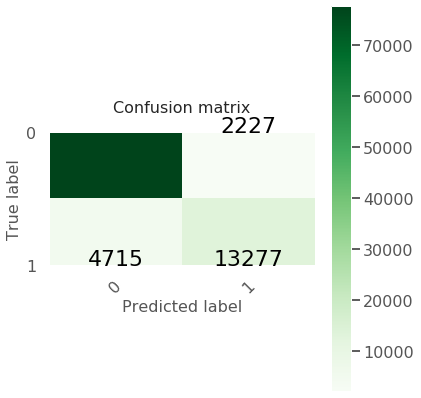

Normalized confusion matrix
[[0.97 0.03]
 [0.26 0.74]]


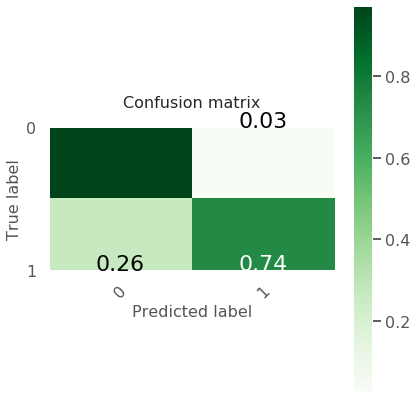

Shape of feature importance vector:  (106,)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.4s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='entropy', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=1, warm_start=False)

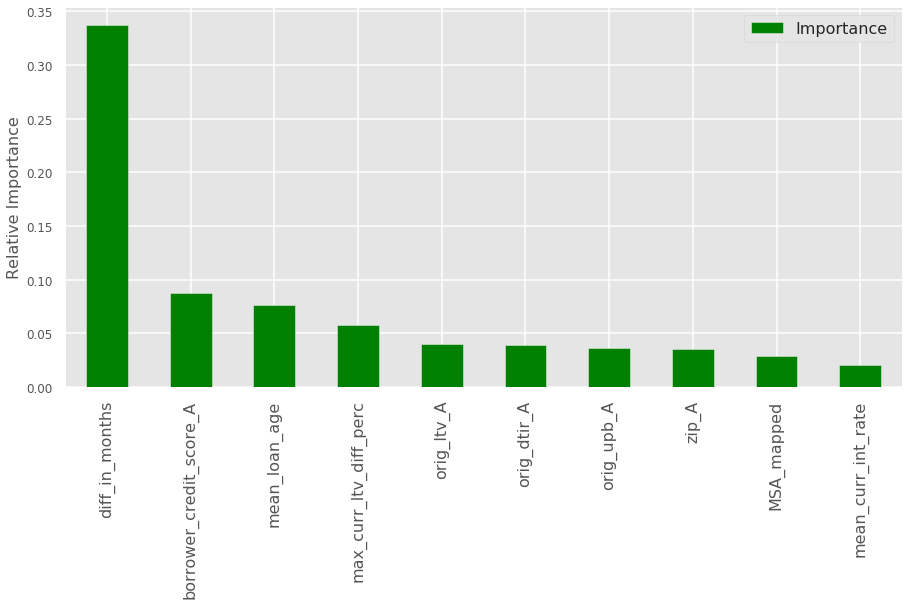

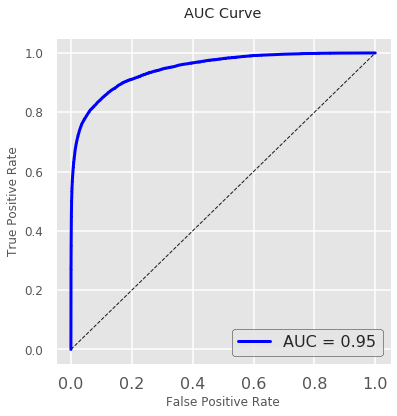

In [58]:
# RandomizedSearchCV - Random Forest
# Train, cross-validate (3-folds) and test

estimators = [100,200,300]
max_depth = [10,20,30]

rf_params = {'criterion':['entropy'],
              'n_estimators':estimators,
              'max_depth':max_depth,
              'n_jobs':[-1],
              'class_weight':['balanced'],
              'verbose':[1]}

rf_func(3, rf_params, 2, X_train, X_test, y_train, y_test)

Best parameters using f1:  {'silent': False, 'scale_pos_weight': 1, 'reg_lambda': 0.1, 'n_jobs': 6, 'n_estimators': 300, 'max_depth': 20, 'colsample_bytree': 0.6}

Grid Scores:

Mean is 0.782 std is 0.001 and params are {'silent': False, 'scale_pos_weight': 1, 'reg_lambda': 1, 'n_jobs': 6, 'n_estimators': 100, 'max_depth': 20, 'colsample_bytree': 0.5}
Mean is 0.789 std is 0.002 and params are {'silent': False, 'scale_pos_weight': 1, 'reg_lambda': 0.1, 'n_jobs': 6, 'n_estimators': 300, 'max_depth': 20, 'colsample_bytree': 0.6}

Threshold is 0.1
Current f1_score is 0.785

Threshold is 0.2
Current f1_score is 0.800

Threshold is 0.3
Current f1_score is 0.802

Threshold is 0.4
Current f1_score is 0.801

Threshold is 0.5
Current f1_score is 0.796

Threshold is 0.6
Current f1_score is 0.791

Threshold is 0.7
Current f1_score is 0.784

Threshold is 0.8
Current f1_score is 0.774

Threshold is 0.9
Current f1_score is 0.753

The best f1_score is 0.802 and the best threshold is 0.3
Train Set Scor

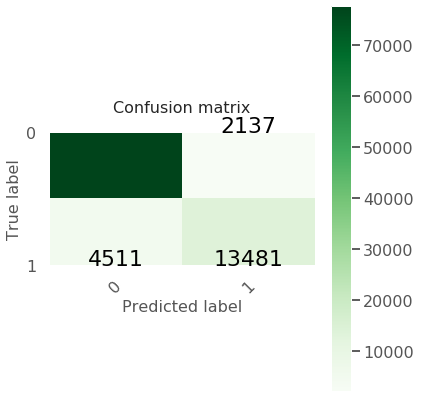

Normalized confusion matrix
[[0.97 0.03]
 [0.25 0.75]]


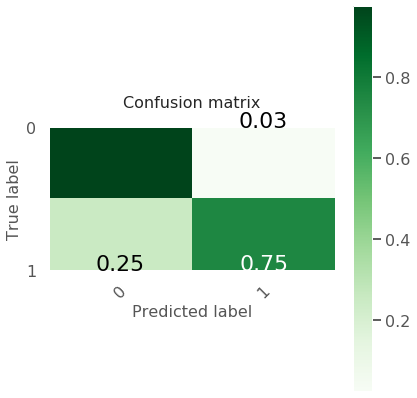

Shape of feature importance vector:  (106,)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=6,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, seed=None,
              silent=False, subsample=1, verbosity=1)

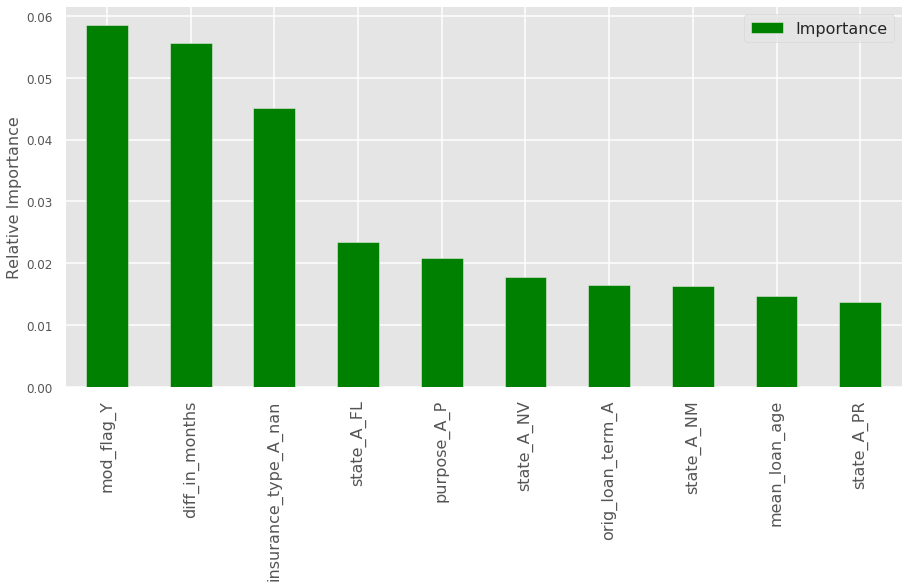

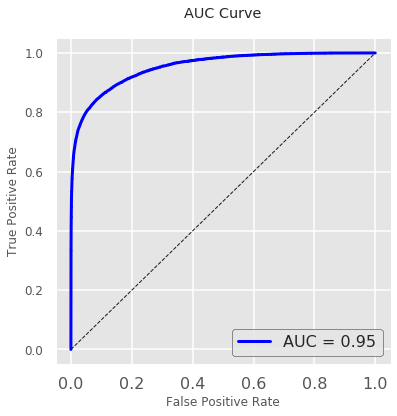

In [59]:
# RandomizedSearchCV - XGB
# Train, cross-validate (3-folds) and test

n_estimators = [100,200,300]
max_depth = [10,20,30]
colsample_bytree = [0.5,0.6]
reg_lambda=[0.1,1]
scale_pos_weight = [1]

xgb_params = {'n_estimators':n_estimators,'colsample_bytree':colsample_bytree,'n_jobs':[6],'reg_lambda':reg_lambda,
              'max_depth':max_depth,'scale_pos_weight':scale_pos_weight, 'silent':[False]}

xgb_func(3, xgb_params, 2, X_train, X_test, y_train, y_test)

## SMOTE Over-Sampling

Through our threshold tuning, we see that 0.5 is not always the best threshold to get the highest f1 score, and that threshold tuning is necessary in obtaining an optimum balance between recall and precision.

Next, we will utilize SMOTE over-sampling to see if we can improve the results of our predictive models. 

In [60]:
# if you put SMOTE(ratio={1:800, 2:800}), it will oversample class 1 until 800 and class 2 until 800.
# If you don't specify a class, will take the original amount and aim to match that

print('Original dataset shape {}'.format(Counter(y_train)))

sm = SMOTE(random_state=10)
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
print('Resampled dataset shape {}'.format(Counter(y_train_smote)))

X_train_smote = pd.DataFrame(X_train_smote, columns=X_train.columns)
display(X_train_smote.head())

Original dataset shape Counter({0: 239280, 1: 53975})
Resampled dataset shape Counter({1: 239280, 0: 239280})


,orig_int_rate_A,orig_upb_A,orig_loan_term_A,orig_ltv_A,borrowers_A,orig_dtir_A,borrower_credit_score_A,num_of_units_A,zip_A,mean_curr_int_rate,max_curr_int_rate,mean_loan_age,diff_in_months,max_curr_ltv_diff_perc,mod_flag_Y,max_servicing_activity_indicator,MSA_mapped,first_time_N,first_time_U,first_time_Y,purpose_A_C,purpose_A_P,purpose_A_R,property_type_A_CO,property_type_A_CP,property_type_A_MH,property_type_A_PU,property_type_A_SF,occupancy_type_A_I,occupancy_type_A_P,occupancy_type_A_S,state_A_AK,state_A_AL,state_A_AR,state_A_AZ,state_A_CA,state_A_CO,state_A_CT,state_A_DC,state_A_DE,state_A_FL,state_A_GA,state_A_GU,state_A_HI,state_A_IA,state_A_ID,state_A_IL,state_A_IN,state_A_KS,state_A_KY,...,state_A_MO,state_A_MS,state_A_MT,state_A_NC,state_A_ND,state_A_NE,state_A_NH,state_A_NJ,state_A_NM,state_A_NV,state_A_NY,state_A_OH,state_A_OK,state_A_OR,state_A_PA,state_A_PR,state_A_RI,state_A_SC,state_A_SD,state_A_TN,state_A_TX,state_A_UT,state_A_VA,state_A_VI,state_A_VT,state_A_WA,state_A_WI,state_A_WV,state_A_WY,relocation_A_Y,seller_name_A_AMTRUST BANK,"seller_name_A_BANK OF AMERICA, N.A.","seller_name_A_CHASE HOME FINANCE, LLC","seller_name_A_CITIMORTGAGE, INC.","seller_name_A_FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB",seller_name_A_FIRST TENNESSEE BANK NATIONAL ASSOCIATION,seller_name_A_FLAGSTAR CAPITAL MARKETS CORPORATION,"seller_name_A_GMAC MORTGAGE, LLC","seller_name_A_HSBC BANK USA, NATIONAL ASSOCIATION","seller_name_A_JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",seller_name_A_OTHER,"seller_name_A_PNC BANK, N.A.",seller_name_A_SUNTRUST MORTGAGE INC.,"seller_name_A_WELLS FARGO BANK, N.A.",insurance_type_A_1.0,insurance_type_A_2.0,insurance_type_A_nan,orig_channel_A_B,orig_channel_A_C,orig_channel_A_R
0,6.250,78000.0,360.0,49.0,1.0,34.0,656.0,1.0,605.0,6.250,6.250,26.0,0.102041,30.983060,0.0,0.0,0.999366,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,6.375,82000.0,360.0,74.0,1.0,51.0,754.0,1.0,486.0,6.375,6.375,30.0,-4.593220,29.008156,0.0,0.0,1.815937,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,6.125,111000.0,240.0,88.0,2.0,15.0,668.0,1.0,405.0,6.125,6.125,15.5,0.000000,3.146844,0.0,0.0,0.015084,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,6.250,400000.0,360.0,74.0,2.0,44.0,751.0,3.0,71.0,6.250,6.250,7.5,-0.125000,10.201166,0.0,0.0,0.908096,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,6.375,125000.0,360.0,55.0,2.0,53.0,679.0,1.0,973.0,6.375,6.375,12.5,-0.038462,20.757652,0.0,0.0,1.815937,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


Best parameters using f1:  {'silent': False, 'scale_pos_weight': 1, 'reg_lambda': 0.1, 'n_jobs': 6, 'n_estimators': 200, 'max_depth': 20, 'colsample_bytree': 0.6}

Grid Scores:

Mean is 0.859 std is 0.180 and params are {'silent': False, 'scale_pos_weight': 1, 'reg_lambda': 1, 'n_jobs': 6, 'n_estimators': 100, 'max_depth': 30, 'colsample_bytree': 0.5}
Mean is 0.872 std is 0.161 and params are {'silent': False, 'scale_pos_weight': 1, 'reg_lambda': 0.1, 'n_jobs': 6, 'n_estimators': 200, 'max_depth': 20, 'colsample_bytree': 0.6}

Threshold is 0.1
Current f1_score is 0.769

Threshold is 0.2
Current f1_score is 0.794

Threshold is 0.3
Current f1_score is 0.800

Threshold is 0.4
Current f1_score is 0.801

Threshold is 0.5
Current f1_score is 0.798

Threshold is 0.6
Current f1_score is 0.793

Threshold is 0.7
Current f1_score is 0.784

Threshold is 0.8
Current f1_score is 0.772

Threshold is 0.9
Current f1_score is 0.750

The best f1_score is 0.801 and the best threshold is 0.4
Train Set Scor

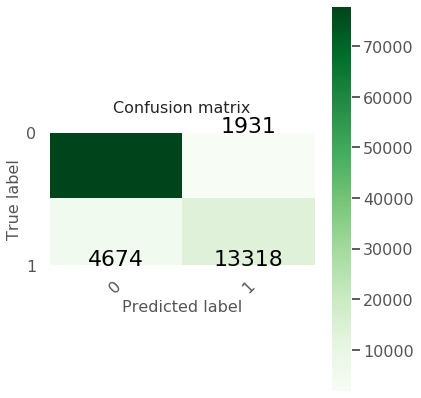

Normalized confusion matrix
[[0.98 0.02]
 [0.26 0.74]]


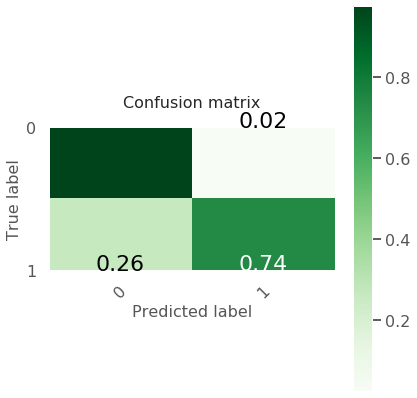

Shape of feature importance vector:  (106,)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=6,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, seed=None,
              silent=False, subsample=1, verbosity=1)

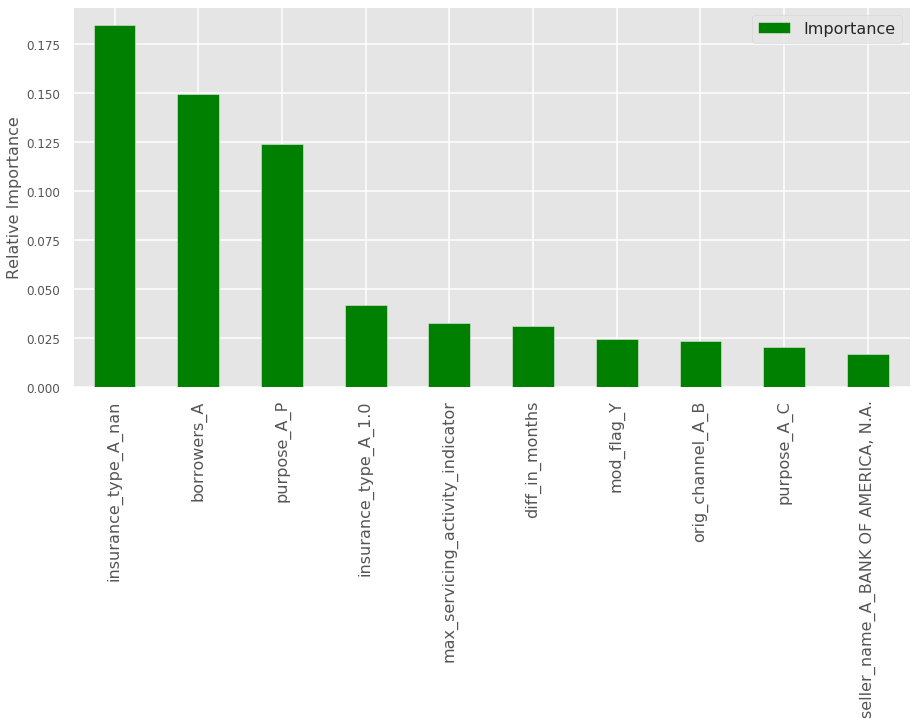

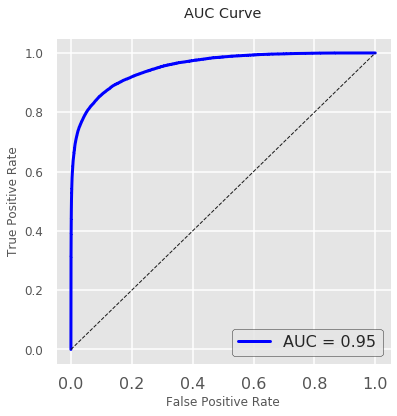

In [61]:
# RandomizedSearchCV - XGB - SMOTE
# Train, cross-validate (3-folds) and test

n_estimators = [100,200,300]
max_depth = [10,20,30]
colsample_bytree = [0.5,0.6]
reg_lambda=[0.1,1]
scale_pos_weight = [1]

xgb_params = {'n_estimators':n_estimators,'colsample_bytree':colsample_bytree,'n_jobs':[6],'reg_lambda':reg_lambda,
              'max_depth':max_depth,'scale_pos_weight':scale_pos_weight, 'silent':[False]}

xgb_func(3, xgb_params, 2, X_train_smote, X_test, y_train_smote, y_test)

From the above, it does not appear SMOTE has improved model performance much as the F1 score and ROC AUC has virtually not changed from the non-SMOTE version. 

<h1 align='center'>Feature Dependency Plotting (Top 4)</h1>

With the feature importances from the Random Forest models, we can now plot them to see how they vary with mortgage default rates to get a clearer picture of how each feature varies with the target. 

In [62]:
depen = joined_df_concat.copy()
depen.head()

,orig_int_rate_A,orig_upb_A,orig_loan_term_A,orig_ltv_A,borrowers_A,orig_dtir_A,borrower_credit_score_A,num_of_units_A,zip_A,mean_curr_int_rate,max_curr_int_rate,mean_loan_age,max_loan_stat,diff_in_months,max_curr_ltv_diff_perc,mod_flag_Y,max_servicing_activity_indicator,MSA_mapped,first_time_N,first_time_U,first_time_Y,purpose_A_C,purpose_A_P,purpose_A_R,property_type_A_CO,property_type_A_CP,property_type_A_MH,property_type_A_PU,property_type_A_SF,occupancy_type_A_I,occupancy_type_A_P,occupancy_type_A_S,state_A_AK,state_A_AL,state_A_AR,state_A_AZ,state_A_CA,state_A_CO,state_A_CT,state_A_DC,state_A_DE,state_A_FL,state_A_GA,state_A_GU,state_A_HI,state_A_IA,state_A_ID,state_A_IL,state_A_IN,state_A_KS,...,state_A_MO,state_A_MS,state_A_MT,state_A_NC,state_A_ND,state_A_NE,state_A_NH,state_A_NJ,state_A_NM,state_A_NV,state_A_NY,state_A_OH,state_A_OK,state_A_OR,state_A_PA,state_A_PR,state_A_RI,state_A_SC,state_A_SD,state_A_TN,state_A_TX,state_A_UT,state_A_VA,state_A_VI,state_A_VT,state_A_WA,state_A_WI,state_A_WV,state_A_WY,relocation_A_Y,seller_name_A_AMTRUST BANK,"seller_name_A_BANK OF AMERICA, N.A.","seller_name_A_CHASE HOME FINANCE, LLC","seller_name_A_CITIMORTGAGE, INC.","seller_name_A_FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB",seller_name_A_FIRST TENNESSEE BANK NATIONAL ASSOCIATION,seller_name_A_FLAGSTAR CAPITAL MARKETS CORPORATION,"seller_name_A_GMAC MORTGAGE, LLC","seller_name_A_HSBC BANK USA, NATIONAL ASSOCIATION","seller_name_A_JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",seller_name_A_OTHER,"seller_name_A_PNC BANK, N.A.",seller_name_A_SUNTRUST MORTGAGE INC.,"seller_name_A_WELLS FARGO BANK, N.A.",insurance_type_A_1.0,insurance_type_A_2.0,insurance_type_A_nan,orig_channel_A_B,orig_channel_A_C,orig_channel_A_R
0,6.625,343000.0,360,86.0,2.0,27.0,751.0,1,809,6.625,6.625,6.5,0,-1.214286,8.583365,0,0,0.025054,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,6.250,400000.0,360,62.0,2.0,35.0,804.0,1,920,6.250,6.250,34.5,0,-0.279412,35.849587,0,0,0.098428,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,6.625,81000.0,360,64.0,1.0,53.0,585.0,1,708,6.625,6.625,21.0,1,0.232558,6.625991,0,1,0.035536,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
3,6.500,119000.0,360,71.0,1.0,35.0,646.0,1,600,6.500,6.500,48.0,1,-2.736842,28.140203,0,1,0.999366,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,6.625,205000.0,360,27.0,1.0,54.0,591.0,1,907,6.625,6.625,18.0,1,-0.351351,58.055377,0,0,0.575485,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [63]:
# Plotting function for comparing features to their default rates

def plotter(binner,palette_choice,binned_feature,feature_label,depen):
    
    feature = re.sub('binned_','',binned_feature)
    depen[binned_feature] = depen[feature].apply(binner)
    display(depen[[feature,binned_feature]].head())
    
    # Set color palette
    if palette_choice == 1:
        palette = ['#db230f', '#db560f', '#e58e02', '#ffe900', '#e1ff00', '#1dff00']              
        sns.set_palette(palette)                     # Red then Green
    elif palette_choice == 2:
        palette = ['#db230f', '#db560f', '#e58e02', '#ffe900', '#e1ff00', '#1dff00']              
        sns.set_palette(list(reversed(palette)))     # Green then Red
    
    # Set style and context for font scaling
    sns.set_style('darkgrid')
    sns.set_context('talk', font_scale=1.6)

    # Set figure and axes objects
    fig, ax = plt.subplots(figsize=(12,6))

    # Calculate defaults vs binned feature
    default_count = (depen[depen['max_loan_stat']==1]
                     .groupby([binned_feature])['max_loan_stat']
                     .count()*100/depen.groupby([binned_feature])['max_loan_stat'].count())

    # Plot data
    sns.barplot(x=default_count.index, y=default_count.values, palette=sns.color_palette(), ax=ax)

    # Set titles
    fig.suptitle('Defaults and '+feature_label)
    ax.set_xlabel(feature_label)
    ax.set_ylabel('Percentage Defaults (%)')

### Compare 'Mean Difference in Months' to Default Rates

,diff_in_months,binned_diff_in_months
0,-1.214286,0 and Below
1,-0.279412,0 and Below
2,0.232558,0 to 1
3,-2.736842,0 and Below
4,-0.351351,0 and Below


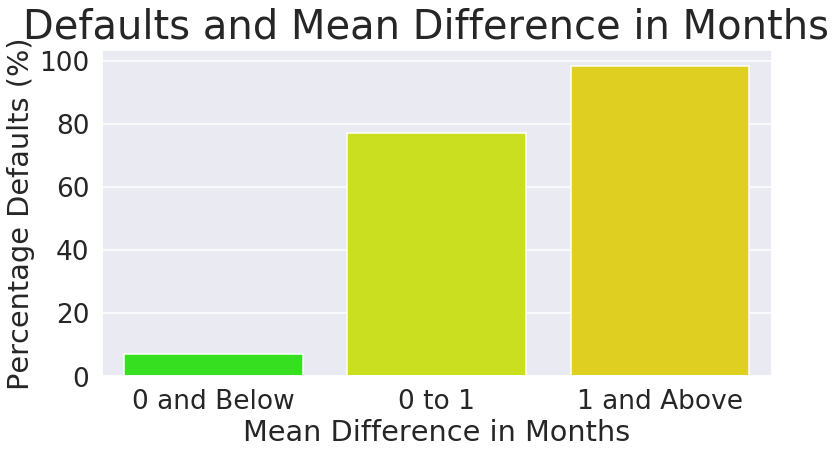

In [64]:
def binner_months(x):
    if 1<x:
        return '1 and Above'
    elif 0<x<=1:
        return '0 to 1'
    else:
        return '0 and Below'
    
plotter(binner_months,2,'binned_diff_in_months','Mean Difference in Months',depen)

We see that having missed payments makes it much more likely that a borrower will go on to actually default. 

### Compare 'Borrower Credit Score' to 'Default Rates'

,borrower_credit_score_A,binned_borrower_credit_score_A
0,751.0,700-800
1,804.0,800 and Above
2,585.0,500-600
3,646.0,600-700
4,591.0,500-600


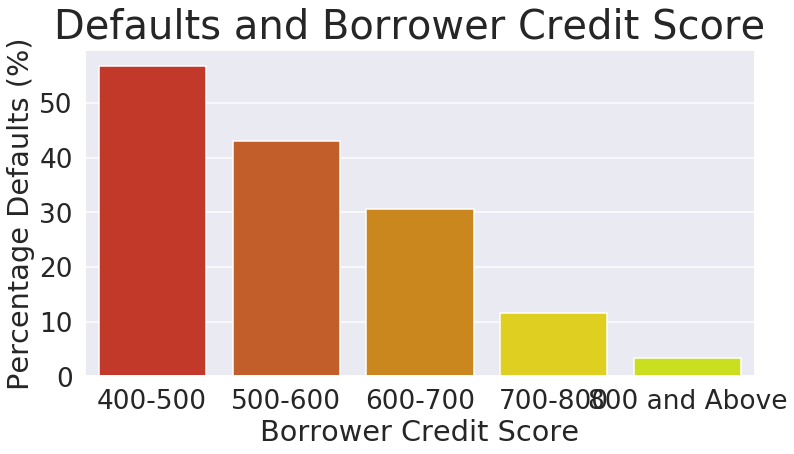

In [65]:
def binner_borrower_credit_score_A(x):
    if 400 <= x < 500:
        return '400-500'
    elif 500 <= x <600:
        return '500-600'
    elif 600 <= x < 700:
        return '600-700'
    elif 700 <= x < 800:
        return '700-800'
    elif 800 <= x:
        return '800 and Above'

plotter(binner_borrower_credit_score_A,1,'binned_borrower_credit_score_A','Borrower Credit Score',depen)

Low credit scores carry much higher risks as seen from the graph above. Default rates are almost 60% for those with credit scores between 400-500. 

### Compare 'Mean Loan Age' to 'Default Rates'

,mean_loan_age,binned_mean_loan_age
0,6.5,0 to 20
1,34.5,20 to 40
2,21.0,20 to 40
3,48.0,40 to 60
4,18.0,0 to 20


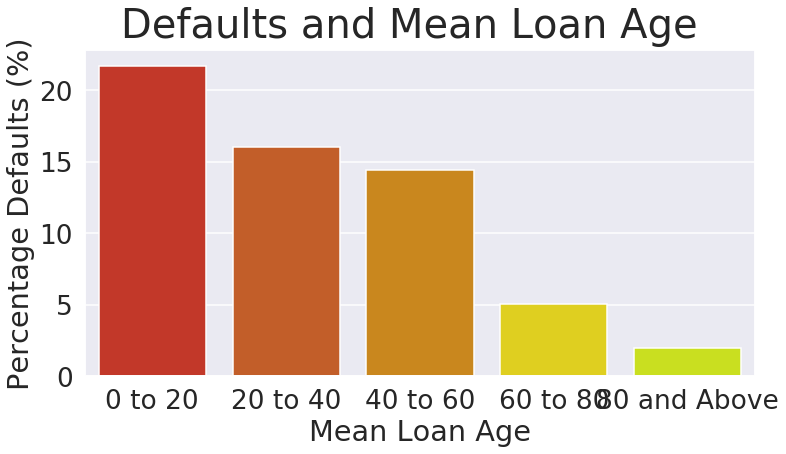

In [66]:
def binner_mean_loan_age(x):
    if 80<x:
        return '80 and Above'
    elif 60<x<=80:
        return '60 to 80'
    elif 40<x<=60:
        return '40 to 60'
    elif 20<x<=40:
        return '20 to 40'
    else:
        return '0 to 20'

plotter(binner_mean_loan_age,1,'binned_mean_loan_age','Mean Loan Age',depen)

Loans that just started out have a higher default rate compared to loans that have been going on for a while. 

### Compare 'Max LTV Percentage Difference' to 'Default Rates'

,max_curr_ltv_diff_perc,binned_max_curr_ltv_diff_perc
0,8.583365,0 to 10
1,35.849587,30 to 40
2,6.625991,0 to 10
3,28.140203,20 to 30
4,58.055377,50 and Above


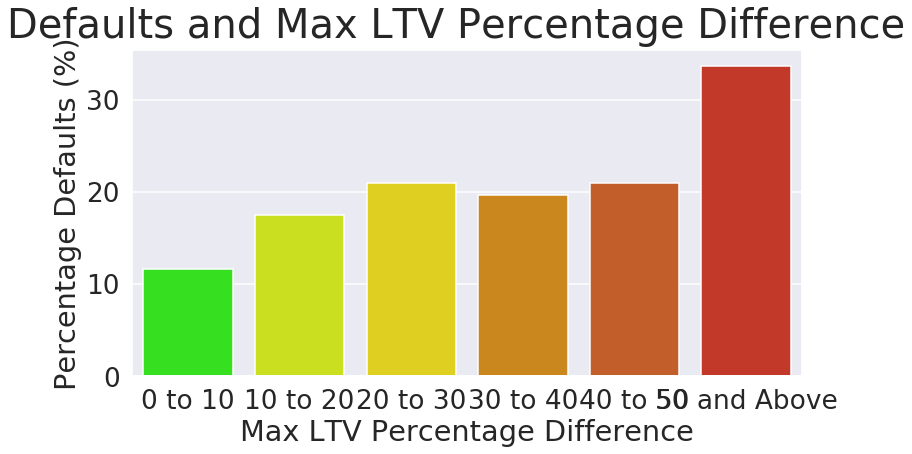

In [67]:
def binner_max_curr_ltv_diff_perc(x):
    if 50<x:
        return '50 and Above'
    elif 40<x<=50:
        return '40 to 50'
    elif 30<x<=40:
        return '30 to 40'
    elif 20<x<=30:
        return '20 to 30'
    elif 10<x<=20:
        return '10 to 20'
    else:
        return '0 to 10'

plotter(binner_max_curr_ltv_diff_perc,2,'binned_max_curr_ltv_diff_perc','Max LTV Percentage Difference',depen)

As expected during the creation of this custom feature, mortgages that have experienced severe drops in their house prices have defaulted at higher rates as their LTVs soared from the crashing house prices. 